In [1]:
import os
import pandas as pd

import numpy as np


import pandas as pd
import sys
print(sys.path)
sys.path.append('/lib/python3.7/site-packages')

from sklearn.decomposition import PCA
import joblib
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, RocCurveDisplay)
from sklearn.preprocessing import label_binarize

import plotly.graph_objects as go
import plotly.offline as pyo
from Funciones import *
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, SGD  # Import other optimizers as needed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tabulate import tabulate

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

import keras
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score


['c:\\Users\\daric\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'c:\\Users\\daric\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\daric\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\daric\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\daric\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\daric\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\daric\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\daric\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Users\\daric\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages']


# Predictive Maintenance Analysis
Based on the input data description provided, we can address the following predictive maintenance question:
**"Given the historical data on aircraft engine operations and failure events, can we predict when an in-service engine will fail?"**
To explore this question, we can reformulate it into three related questions, each suited for different types of machine learning models. The choice of model will depend on specific business requirements. 
## 1. Regression Model
**Question:** How many additional cycles can an in-service engine be expected to operate before it fails?
**Objective:** Predict the remaining operational cycles of an engine.
## 2. Binary Classification Model
**Question:** Is the engine expected to fail within the next `w1` cycles?
**Objective:** Determine whether the engine will fail within a specified time frame.
## 3. Multi-class Classification Model
**Question:** Will the engine fail within one of the following time windows: [1, `w0`] cycles, [w0+1, `w1`] cycles, or not within `w1` cycles?
**Objective:** Classify the engine's failure time into one of the predefined time windows.
While all three approaches are explored, typically only one model will be selected based on the specific needs and constraints of the business.

In [2]:
os.chdir("C:/Users/daric/OneDrive/Desktop/TFM/tfm_predictive_maintenance/data")
train_df=pd.read_csv("train_df.csv")
test_df=pd.read_csv("test_df.csv")

In [3]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


Now generate labels for training data

In [4]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


Now for test_df the transformations

In [5]:
# generate column max for test data
truth_df = pd.read_csv('C:/Users/daric/OneDrive/Desktop/TFM/tfm_predictive_maintenance/notebook_analysis/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,cycle_norm,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0.00000,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0.00277,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0.00554,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0.00831,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0.01108,0,0


In [6]:
sequence_length = 50
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape


(15631, 50, 25)

In [7]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape



(15631, 1)

#  LSTM Regresion model
Modeling
Traditional predictive maintenance models often rely on feature engineering, a process involving the manual construction of relevant features based on domain expertise. This approach is typically tailored to specific problem contexts and datasets, making such models less generalizable across different business scenarios. One of the significant advantages of deep learning techniques, particularly Long Short-Term Memory (LSTM) networks, in predictive maintenance is their ability to automatically extract meaningful features from raw data, thereby obviating the need for extensive manual feature engineering.

In the context of time-series data, a critical parameter for LSTMs is the sequence length, which defines the look-back window for the network. This concept is analogous to selecting a window size (e.g., 5 cycles) for computing rolling features such as the mean and standard deviation from sensor data, as seen in traditional predictive maintenance models. The advantage of employing LSTMs lies in their capacity to automatically learn abstract features from the sequence of sensor values within the designated window, rather than relying on pre-engineered features. The expectation is that LSTMs will capture patterns in the sensor data that precede failures, encoding these patterns directly from the data.

A notable benefit of LSTMs is their proficiency in handling long-term dependencies within sequences, a challenge often encountered in traditional feature engineering approaches. For instance, calculating rolling averages over a large window size, such as 50 cycles, may result in information loss due to the smoothing effect and the abstraction of data. In contrast, LSTMs can process longer sequences without discarding critical information, leveraging the entire window of data to improve predictive performance. The following sections will illustrate this approach in detail.

In [8]:
# Define the feature columns and label column
sequence_cols = [
    'setting1', 'setting2', 'setting3', 'cycle_norm',
    's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
    's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17',
    's18', 's19', 's20', 's21'
]
label_col = 'RUL'
sequence_length = 50

# Create sequences and labels
X_rul, y_rul = create_sequences_lstm_rul(train_df, sequence_length, sequence_cols, label_col)

print(f"Shape of X: {X_rul.shape}")
print(f"Shape of y: {y_rul.shape}")

Shape of X: (15631, 50, 25)
Shape of y: (15631,)


c:\Users\daric\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 8411.7148 - val_loss: 10784.2656
Epoch 2/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 6526.4146 - val_loss: 9413.1523
Epoch 3/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 5653.3975 - val_loss: 8318.3740
Epoch 4/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 69ms/step - loss: 4915.1182 - val_loss: 7443.0771
Epoch 5/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 4302.8940 - val_loss: 6751.9312
Epoch 6/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 3963.2720 - val_loss: 6207.1924
Epoch 7/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 3443.6729 - val_loss: 5791.4434
Epoch 8/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - loss: 3290.1960 - val_loss: 5479.5352
Epoch 9/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - loss: 3103.1687 - val_loss: 5245.6826
Epoch 10/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 3101.6228 - val_loss: 5075.3760
Epoch 11/30
196/196 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - l

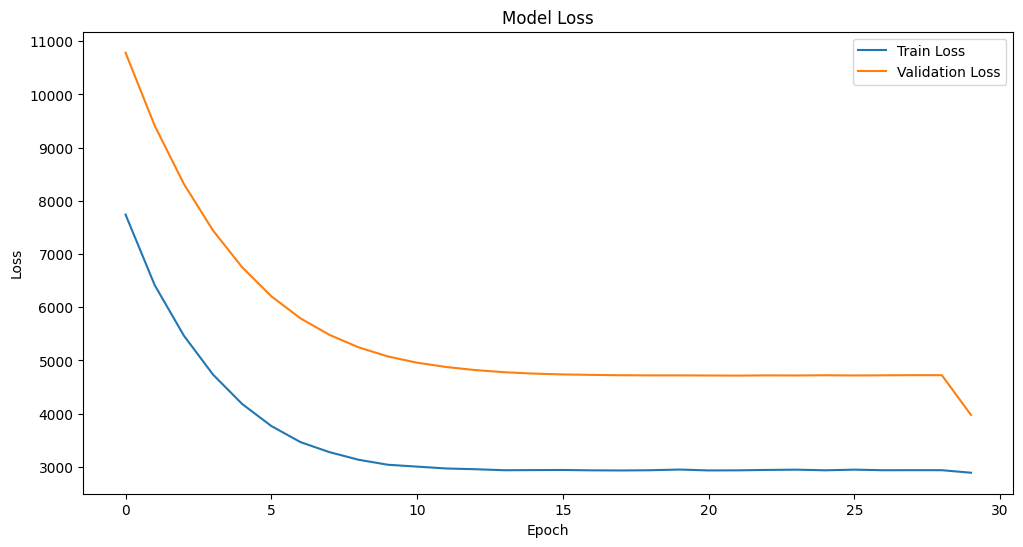

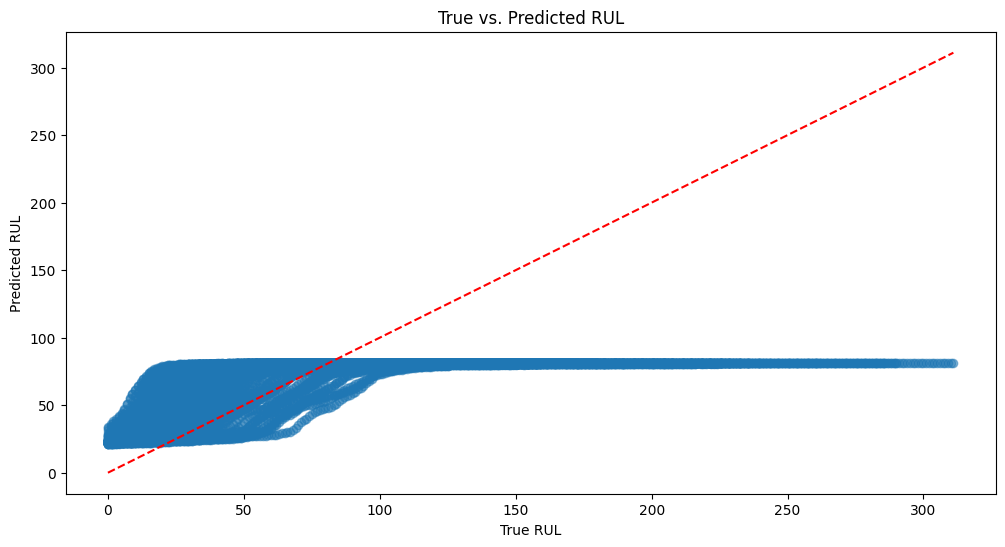

In [9]:
units_lstm1 = 100
units_lstm2 = 50
dropout_rate = 0.15

# Create model
model1_lstm_rul = create_model(units_lstm1, units_lstm2, dropout_rate)

# Define training parameters
epochs = 30
batch_size = 64
validation_split = 0.2

# Evaluate and plot
results_traindf_model1_lstm_rul = evaluate_and_plot(model1_lstm_rul, X_rul, y_rul, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
   True RUL  Predicted RUL
0       144      80.884521
1       143      80.897987
2       142      80.932205
3       141      80.919090
4       140      80.901680
Mean Absolute Error Test: 48.779983325145956
Root Mean Squared Error Test: 62.28392128282031


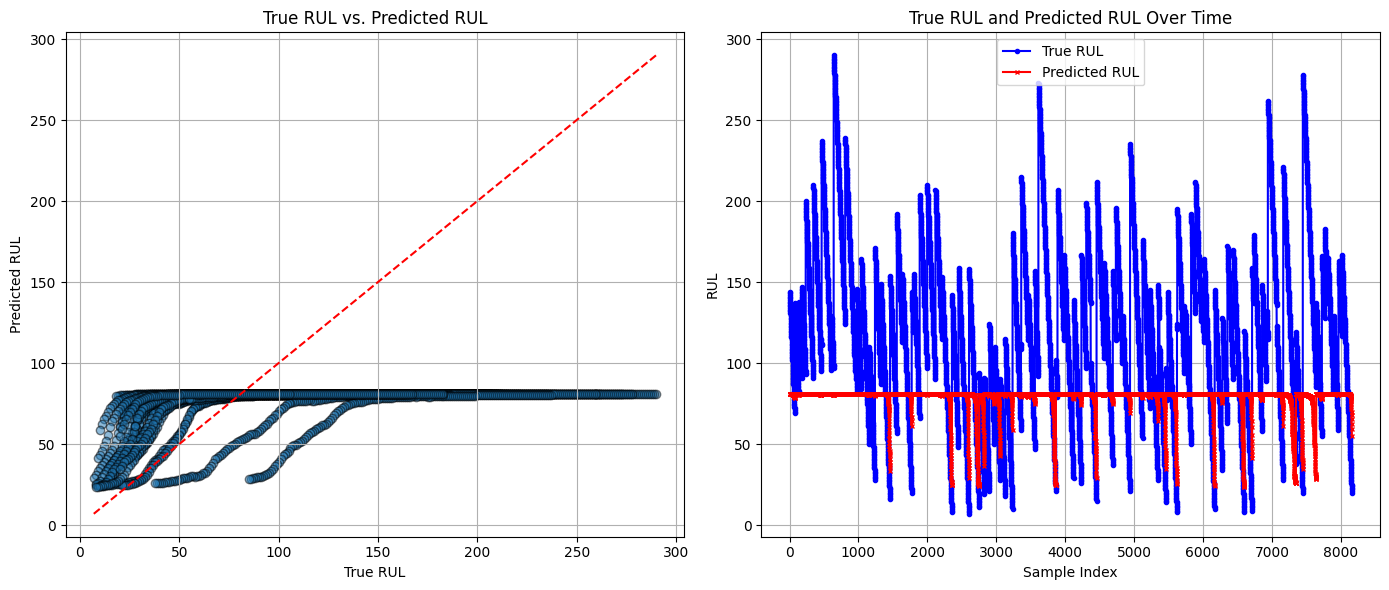

In [11]:
# Create sequences and labels for the test_df
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test, y_test = create_sequences_lstm_rul(test_df, sequence_length, sequence_cols, label_col)

# Predict RUL for the test sequences
predictions_model1_lstm_rul = model1_lstm_rul.predict(X_test)

# Create DataFrame with true and predicted values
resulttest_df_model1_lstm_rul = pd.DataFrame({
    'True RUL': y_test,
    'Predicted RUL': predictions_model1_lstm_rul.flatten()
})

# Display the first few rows of the DataFrame
print(resulttest_df_model1_lstm_rul.head())

# Calculate accuracy metrics
mae = mean_absolute_error(resulttest_df_model1_lstm_rul['True RUL'], resulttest_df_model1_lstm_rul['Predicted RUL'])
rmse = np.sqrt(mean_squared_error(resulttest_df_model1_lstm_rul['True RUL'], resulttest_df_model1_lstm_rul['Predicted RUL']))

print(f"Mean Absolute Error Test: {mae}")
print(f"Root Mean Squared Error Test: {rmse}")



evaluate_rul_performance_lstm(y_test, predictions_model1_lstm_rul,)


Epoch 1/35


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 8660.9570 - val_loss: 10037.1875
Epoch 2/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 6778.4609 - val_loss: 8582.6826
Epoch 3/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 5707.4473 - val_loss: 7457.4023
Epoch 4/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 4778.6821 - val_loss: 6594.4731
Epoch 5/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 4300.5078 - val_loss: 5945.3179
Epoch 6/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 3851.9438 - val_loss: 5465.9604
Epoch 7/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 3654.3364 - val_loss: 5123.9434
Epoch 8/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 3405.8474 - val_loss: 4883.1606
Epoch 9/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 3258.4397 - val_loss: 4717.6191
Epoch 10/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 3301.9802 - val_loss: 4610.0117
Epoch 11/35
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 3202.3315 - val_

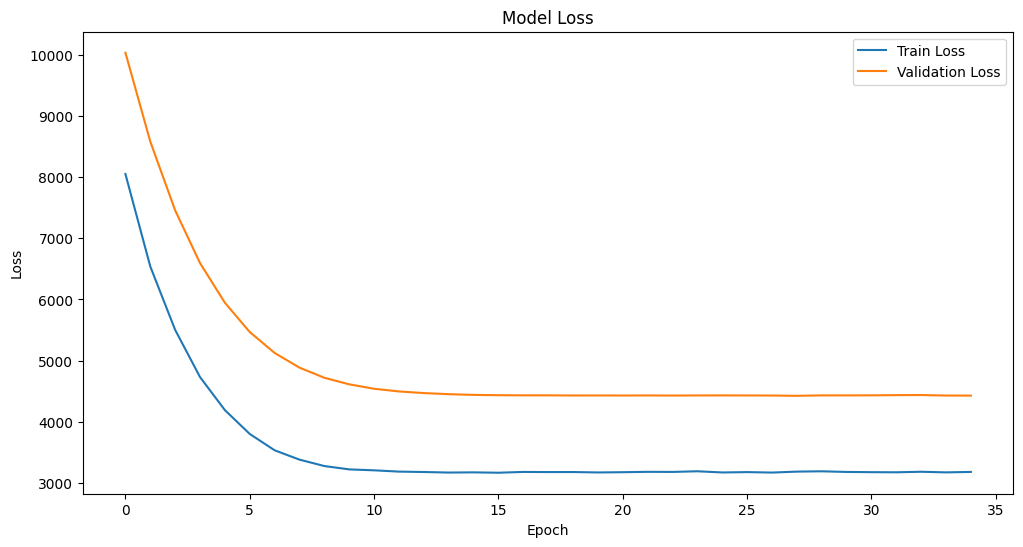

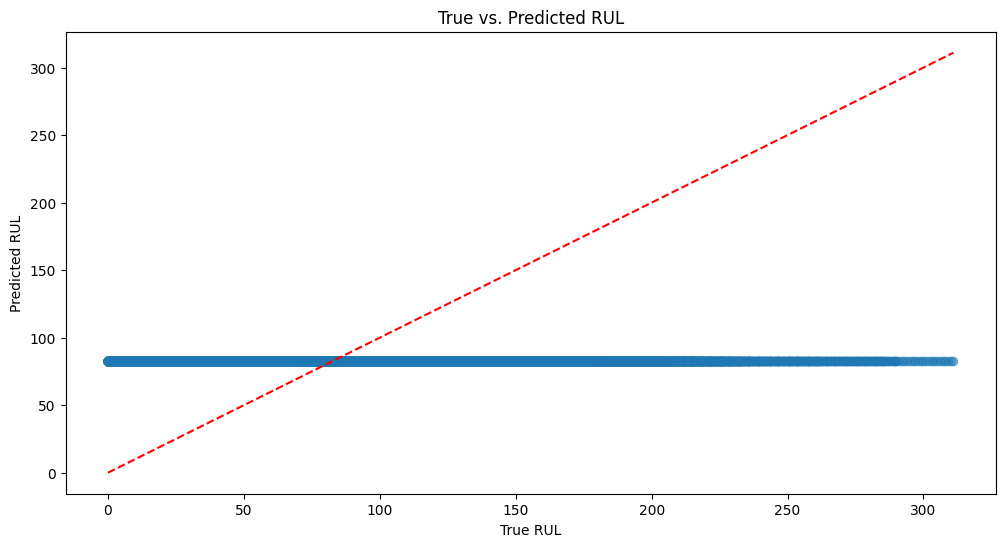

In [11]:
# Define model parameters
units_lstm1 = 75
units_lstm2 = 50
dropout_rate = 0.2

# Create model
model2_lstm_RUL = create_model(units_lstm1, units_lstm2, dropout_rate)

# Define training parameters
epochs = 35
batch_size = 64
validation_split = 0.1

# Evaluate and plot
results_traindf_model2_lstm_RUL = evaluate_and_plot(model2_lstm_RUL, X_rul, y_rul, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
   True RUL  Predicted RUL
0       144      82.974426
1       143      82.974434
2       142      82.974434
3       141      82.974434
4       140      82.974434
Mean Absolute Error Test: 49.29190925779485
Root Mean Squared Error Test: 62.03584741923482
Mean Absolute Error (for RUL < 30): 61.78222912219914
Mean Squared Error (for RUL < 30): 3850.8602735624117


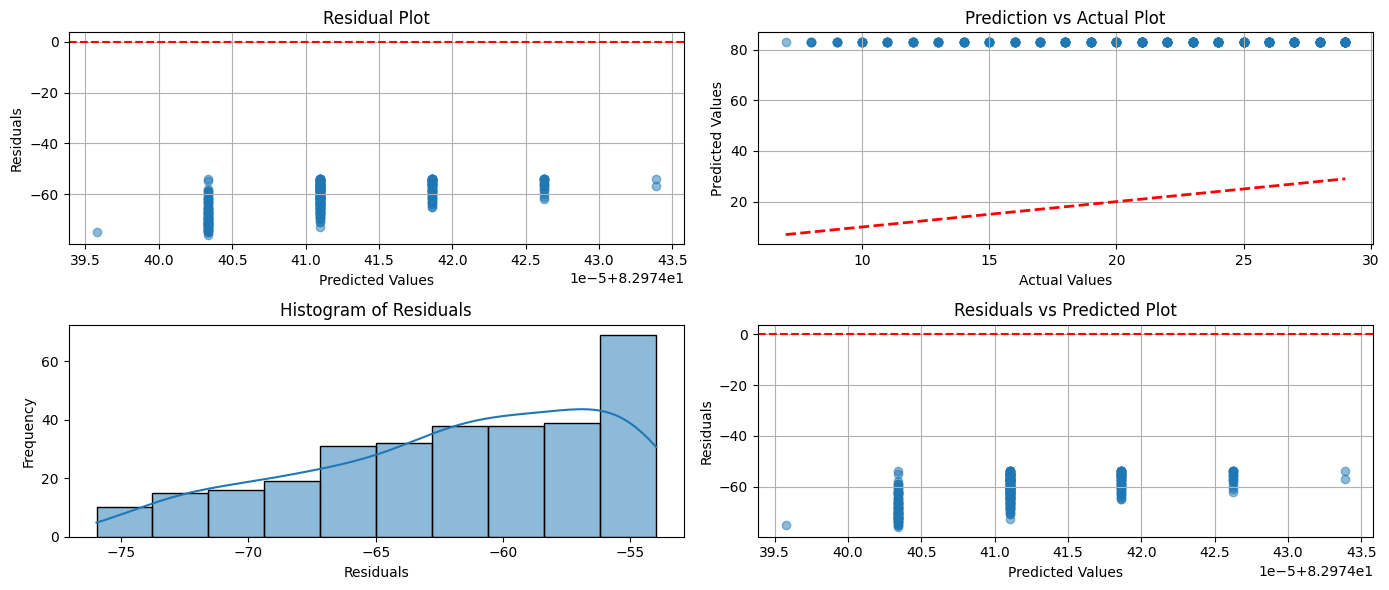

In [12]:
# Predict RUL for the test sequences
predictions_model2_lstm_rul = model2_lstm_RUL.predict(X_test)

# Create DataFrame with true and predicted values
resulttest_df_model2_lstm_rul = pd.DataFrame({
    'True RUL': y_test,
    'Predicted RUL': predictions_model2_lstm_rul.flatten()
})

# Display the first few rows of the DataFrame
print(resulttest_df_model2_lstm_rul.head())

# Calculate accuracy metrics
mae = mean_absolute_error(resulttest_df_model2_lstm_rul['True RUL'], resulttest_df_model2_lstm_rul['Predicted RUL'])
rmse = np.sqrt(mean_squared_error(resulttest_df_model2_lstm_rul['True RUL'], resulttest_df_model2_lstm_rul['Predicted RUL']))

print(f"Mean Absolute Error Test: {mae}")
print(f"Root Mean Squared Error Test: {rmse}")


evaluate_rul_performance_lstm(y_test, predictions_model2_lstm_rul, threshold=30)


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 8178.7676 - val_loss: 8697.1416
Epoch 2/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 5639.5693 - val_loss: 6741.2080
Epoch 3/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 4258.1250 - val_loss: 5590.1074
Epoch 4/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 3588.3000 - val_loss: 4967.7827
Epoch 5/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 3279.8630 - val_loss: 4655.7856
Epoch 6/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 3210.2051 - val_loss: 4516.3374
Epoch 7/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 3170.3350 - val_loss: 4461.4487
Epoch 8/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 3203.3777 - val_loss: 4442.1191
Epoch 9/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 3124.2595 - val_loss: 4434.5039
Epoch 10/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 3183.4888 - val_loss: 4435.6807
Epoch 11/40
440/440 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - lo

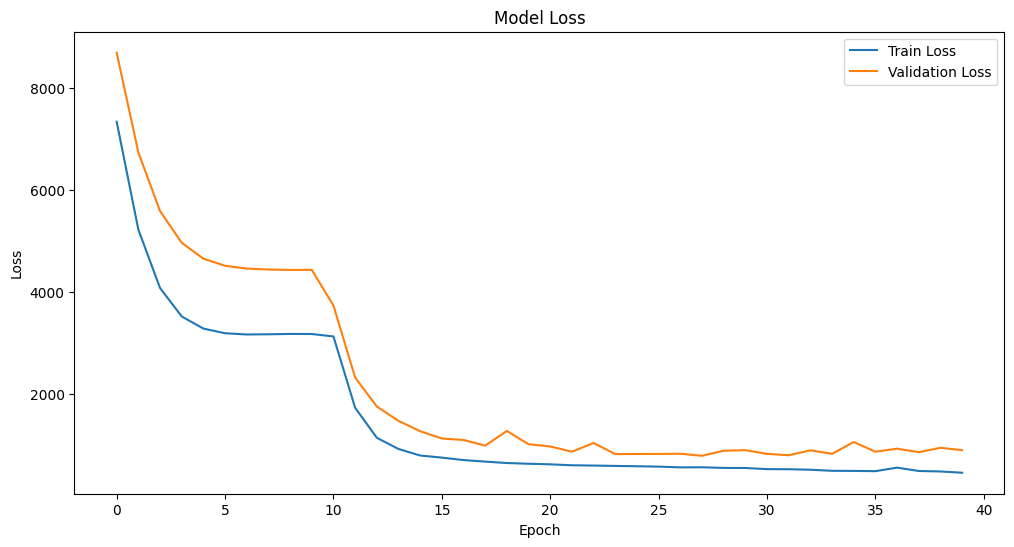

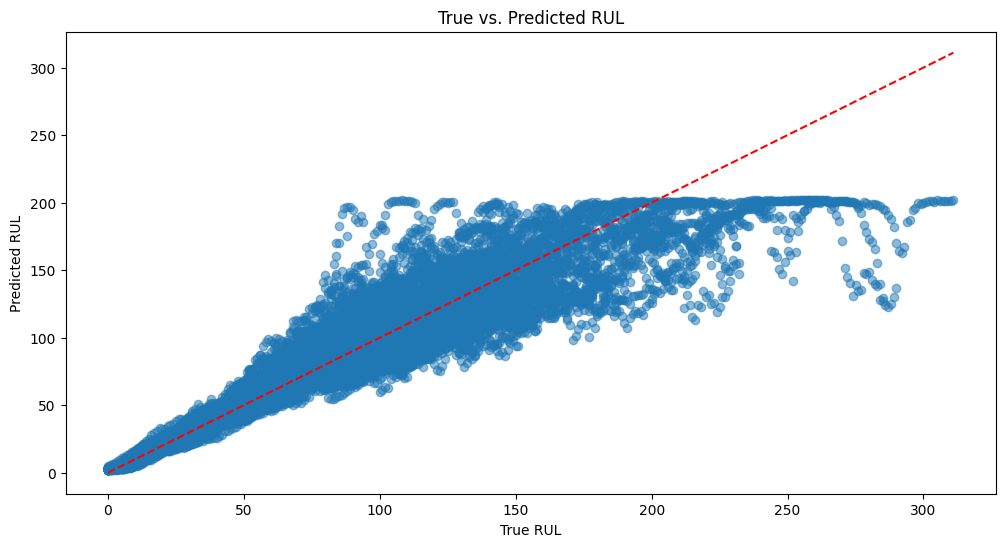

In [13]:
units_lstm1 = 75
units_lstm2 = 50
dropout_rate = 0.2
epochs = 40
batch_size = 32
validation_split = 0.1
model3_lstm_RUL = create_model(units_lstm1, units_lstm2, dropout_rate)
results_traindf_model3_lstm_RUL = evaluate_and_plot(model3_lstm_RUL, X_rul, y_rul, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
   True RUL  Predicted RUL
0       144      93.308739
1       143      95.293350
2       142     104.581383
3       141     111.932335
4       140     118.113861
Mean Absolute Error Test: 24.791061459379844
Root Mean Squared Error Test: 35.525195970268186
Mean Absolute Error (for RUL < 30): 2.075171810796284
Mean Squared Error (for RUL < 30): 7.610331395747309


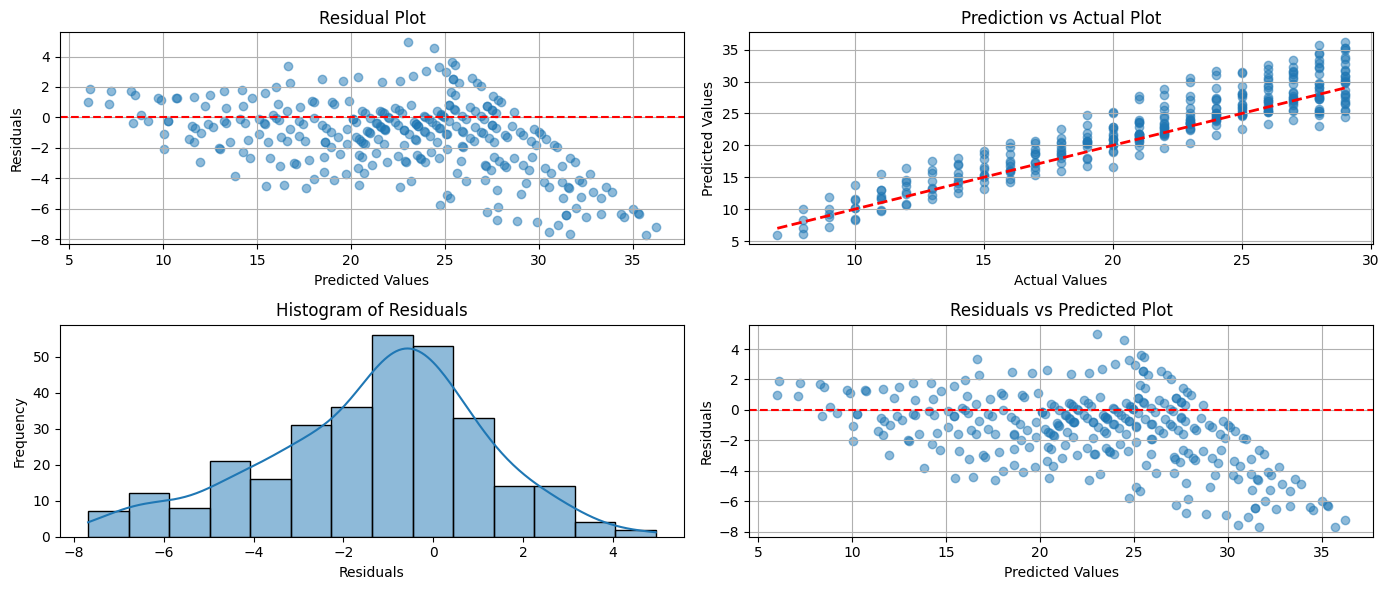

In [14]:
# Predict RUL for the test sequences
predictions_model3_lstm_RUL = model3_lstm_RUL.predict(X_test)

# Create DataFrame with true and predicted values
resulttest_df_model3_lstm_rul = pd.DataFrame({
    'True RUL': y_test,
    'Predicted RUL': predictions_model3_lstm_RUL.flatten()
})

# Display the first few rows of the DataFrame
print(resulttest_df_model3_lstm_rul.head())

# Calculate accuracy metrics
mae = mean_absolute_error(resulttest_df_model3_lstm_rul['True RUL'], resulttest_df_model3_lstm_rul['Predicted RUL'])
rmse = np.sqrt(mean_squared_error(resulttest_df_model3_lstm_rul['True RUL'], resulttest_df_model3_lstm_rul['Predicted RUL']))

print(f"Mean Absolute Error Test: {mae}")
print(f"Root Mean Squared Error Test: {rmse}")

evaluate_rul_performance_lstm(y_test, predictions_model3_lstm_RUL, threshold=30)


Epoch 1/45


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



880/880 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 8086.5347 - val_loss: 7626.5181
Epoch 2/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 4699.5039 - val_loss: 5545.6221
Epoch 3/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 3572.5815 - val_loss: 4742.6162
Epoch 4/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 3240.8848 - val_loss: 4510.3647
Epoch 5/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 3196.3464 - val_loss: 4445.3467
Epoch 6/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 3194.0542 - val_loss: 4433.0605
Epoch 7/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 3152.3987 - val_loss: 3433.6443
Epoch 8/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - loss: 1862.5508 - val_loss: 2310.1384
Epoch 9/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 1171.0874 - val_loss: 1602.3381
Epoch 10/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 998.4832 - val_loss: 1397.2064
Epoch 11/45
880/880 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 823.1675

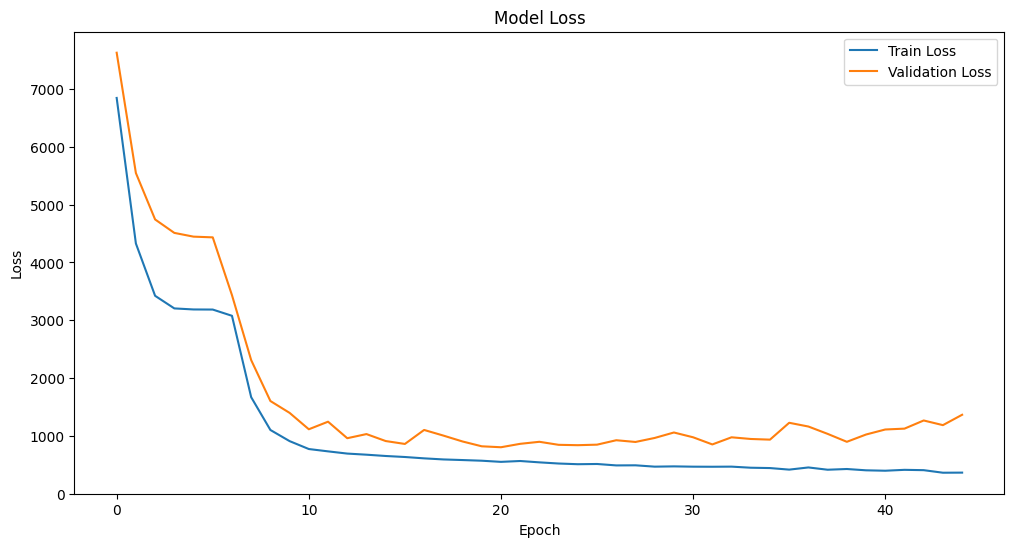

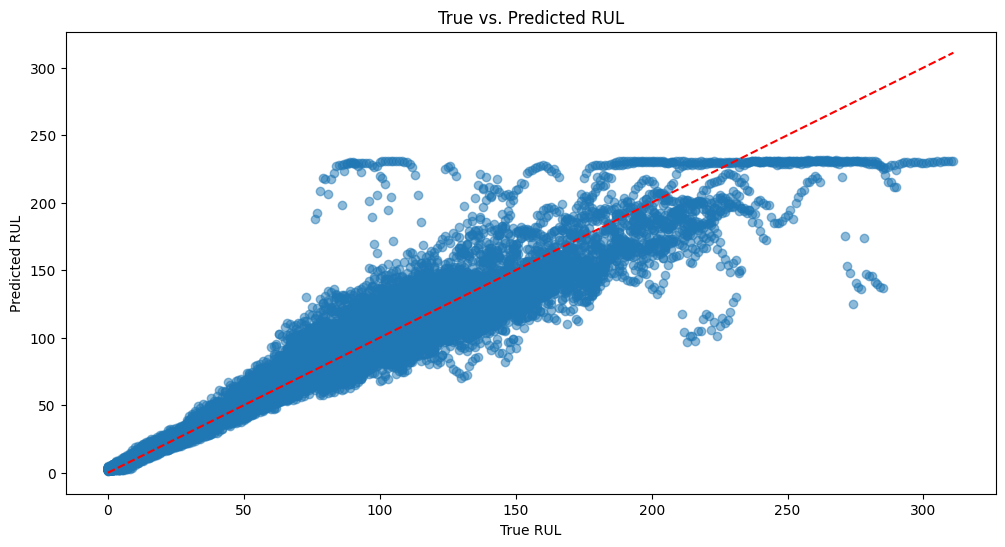

In [15]:
units_lstm1 = 75
units_lstm2 = 40
dropout_rate = 0.2
epochs = 45
batch_size = 16
validation_split = 0.1
model4_lstm_rul = create_model(units_lstm1, units_lstm2, dropout_rate)
results_traindf_model4_lstm_rul = evaluate_and_plot(model4_lstm_rul, X_rul, y_rul, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
   True RUL  Predicted RUL
0       144     109.498260
1       143     114.457199
2       142     125.196152
3       141     136.561279
4       140     146.195038
Mean Absolute Error Test: 25.44652453452692
Root Mean Squared Error Test: 36.4947300321989
Mean Absolute Error (for RUL < 30): 2.394919292934554
Mean Squared Error (for RUL < 30): 9.778443495272036


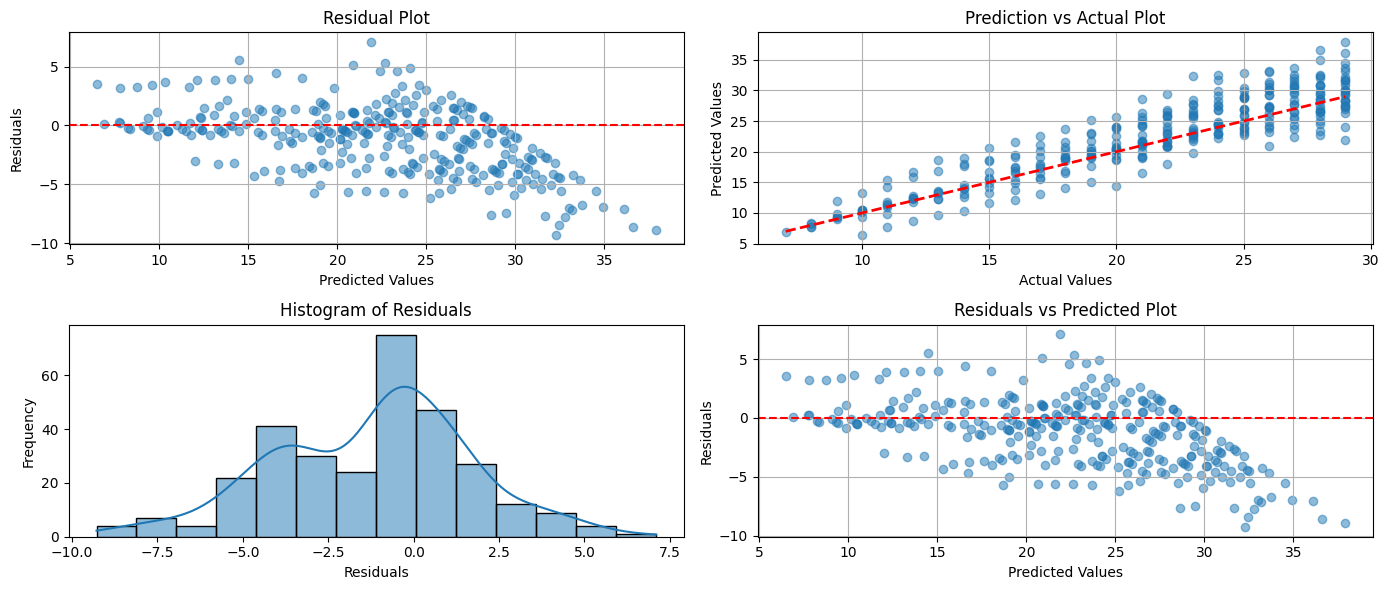

In [16]:
# Predict RUL for the test sequences
predictions_model4_lstm_RUL = model4_lstm_rul.predict(X_test)

# Create DataFrame with true and predicted values
resulttest_df_model4_lstm_rul = pd.DataFrame({
    'True RUL': y_test,
    'Predicted RUL': predictions_model4_lstm_RUL.flatten()
})

# Display the first few rows of the DataFrame
print(resulttest_df_model4_lstm_rul.head())

# Calculate accuracy metrics
mae = mean_absolute_error(resulttest_df_model4_lstm_rul['True RUL'], resulttest_df_model4_lstm_rul['Predicted RUL'])
rmse = np.sqrt(mean_squared_error(resulttest_df_model4_lstm_rul['True RUL'], resulttest_df_model4_lstm_rul['Predicted RUL']))

print(f"Mean Absolute Error Test: {mae}")
print(f"Root Mean Squared Error Test: {rmse}")

evaluate_rul_performance_lstm(y_test, predictions_model4_lstm_RUL, threshold=30)

# LSTM Network for binary clasification
We proceed to construct a deep learning network designed for binary classification. The architecture includes the following layers:

- First Layer: An LSTM layer with 100 units, responsible for capturing temporal dependencies in the data.
- Second Layer: A subsequent LSTM layer with 75 units, further refining the learned features and enhancing the model's ability to capture complex patterns.
- Dropout Layers: Dropout is applied following each LSTM layer to mitigate overfitting and improve the generalization of the model.
- Final Layer: A Dense output layer with a single unit and a sigmoid activation function, which is suitable for binary classification tasks.
This network design aims to effectively learn and predict binary outcomes based on the temporal sequences in the dataset.

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50, 100)        │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 75)             │        52,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,276 (403.42 KB)

 Trainable params: 103,276 (403.42 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8576 - loss: 0.3480 - val_accuracy: 0.9655 - val_loss: 0.0960
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9528 - loss: 0.1142 - val_accuracy: 0.9680 - val_loss: 0.0643
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9697 - loss: 0.0709 - val_accuracy: 0.9578 - val_loss: 0.1024
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9606 - loss: 0.0918
Accurracy: 0.9598873853683472
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

Metrics:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.959887 |
+-----------+----------+
| Precision | 0.964675 |
+-----------+----------+
| Recall    | 0.828065 |
+-----------+----------+
| F1 Score  | 0.891165 |
+-----------+----------+


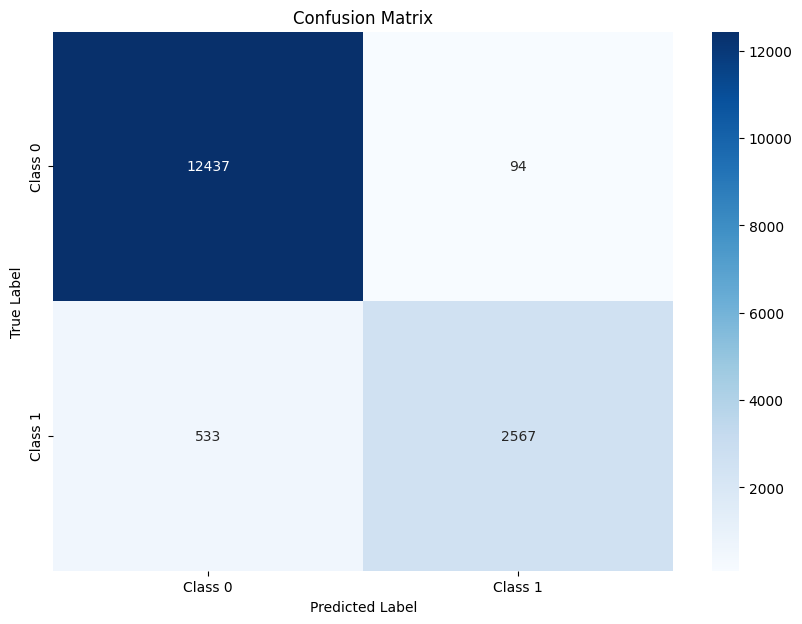

In [17]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
lstm_units_1 = 100
lstm_units_2 = 75
dropout_rate = 0.15
optimizer_name = 'adam'
model1_LSTM_binary = build_lstm_network(sequence_length, nb_features, nb_out, lstm_units_1, lstm_units_2, dropout_rate, optimizer_name)
print(model1_LSTM_binary.summary())

model1_LSTM_binary.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

# training metrics
scores_model1_lstm = model1_LSTM_binary.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores_model1_lstm[1]))

plot_confusion_matrix(model1_LSTM_binary, seq_array, label_array, verbose=1, batch_size=200)

this is for testin in test_data

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
   id  cycle  predicted_label1
0   3     50                 0
1   3     51                 0
2   3     52                 0
3   3     53                 0
4   3     54                 0

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|   Class 0    | 0.9841921832213094 | 0.9979805629180866 | 0.9910384157423074 |       7923.0       |
|   Class 1    | 0.9276018099547512 | 0.6174698795180723 | 0.7414104882459313 |       332.0        |
|   accuracy   | 0.9826771653543307 | 0.9826771653543307 | 0.9826771653543307 | 0.9826771653543307 |
|  macro avg   | 0.9558969965880303 | 0.8077252212180794 | 0.8662244519941193 |       8255.0       |
| weighted avg | 0.9819162287786084 | 0.982

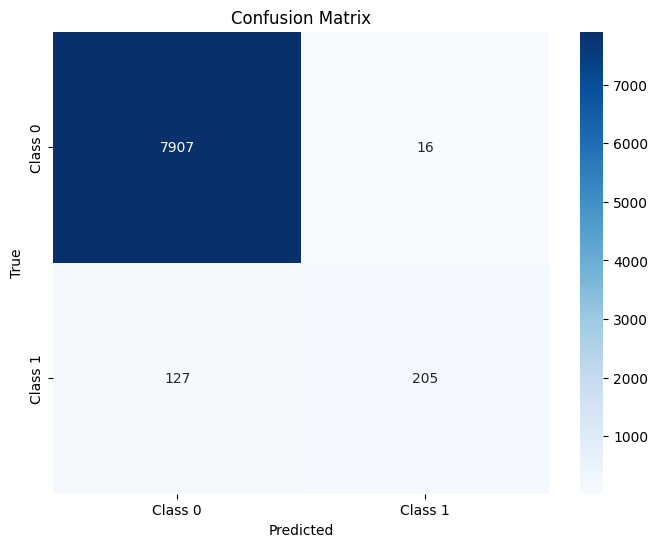

In [18]:
# Generate sequences from test_df
seq_gen_test = gen_sequence_bin_lstm(test_df, sequence_length, sequence_cols)
seq_array_test = np.array(seq_gen_test).astype(np.float32)

# Predict labels using the trained model
predictions_label1 = model1_LSTM_binary.predict(seq_array_test, batch_size=200)
predictions_label1 = (predictions_label1 > 0.5).astype(int).flatten()

# Generate matching id and cycle arrays
ids = []
cycles = []
for _, group in test_df.groupby('id'):
    for start in range(len(group) - sequence_length + 1):
        ids.append(group['id'].iloc[start])
        cycles.append(group['cycle'].iloc[start + sequence_length - 1])

# Convert to numpy arrays
ids = np.array(ids)
cycles = np.array(cycles)
label1_values = get_label1_values(test_df, sequence_length)

# Ensure all lengths match
num_test_sequences = len(predictions_label1)
assert len(ids) == num_test_sequences, "Length mismatch for 'id'"
assert len(cycles) == num_test_sequences, "Length mismatch for 'cycle'"
assert len(label1_values) == num_test_sequences, "Length mismatch for 'label1'"

# Create output DataFrame
output_df = pd.DataFrame({
    'id': ids,
    'cycle': cycles,
    'predicted_label1': predictions_label1,

})

print(output_df.head())

evaluate_model_confusiontabulate(label1_values, predictions_label1)

Lets try more approaches to see a better fit to LSTM

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50, 75)         │        30,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50, 75)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        25,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,551 (217.00 KB)

 Trainable params: 55,551 (217.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8185 - loss: 0.3997 - val_accuracy: 0.9693 - val_loss: 0.1117
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9597 - loss: 0.1113 - val_accuracy: 0.9591 - val_loss: 0.1004
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9604 - loss: 0.0950 - val_accuracy: 0.9795 - val_loss: 0.0612
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9683 - loss: 0.0747 - val_accuracy: 0.9859 - val_loss: 0.0436
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9711 - loss: 0.0659 - val_accuracy: 0.9847 - val_loss: 0.0354
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.9736 - loss: 0.0642 - val_accuracy: 0.9693 - val_loss: 0.0669
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9673 - loss: 0.0724
Accurracy: 0.9648774862289429
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

Metrics:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Ac

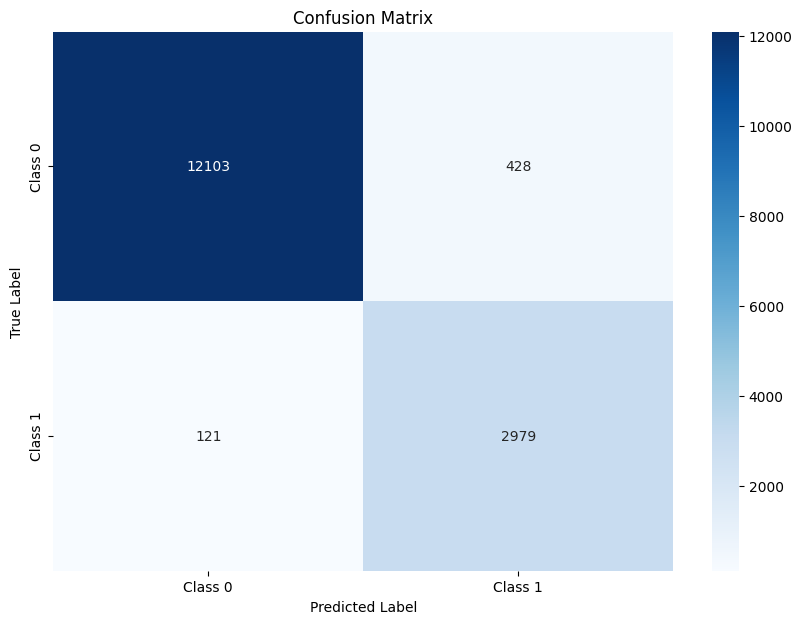

In [19]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
lstm_units_1 = 75
lstm_units_2 = 50
dropout_rate = 0.2
optimizer_name = 'adam'
model2_LSTM_binary = build_lstm_network(sequence_length, nb_features, nb_out, lstm_units_1, lstm_units_2, dropout_rate, optimizer_name)
print(model2_LSTM_binary.summary())

model2_LSTM_binary.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

scores_model2_lstm = model2_LSTM_binary.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores_model2_lstm[1]))
plot_confusion_matrix(model2_LSTM_binary, seq_array, label_array, verbose=1, batch_size=200)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
   id  cycle  predicted_label1
0   3     50                 0
1   3     51                 0
2   3     52                 0
3   3     53                 0
4   3     54                 0

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|   Class 0    | 0.9927637425415767 | 0.9869998737851824 | 0.9898734177215189 |       7923.0       |
|   Class 1    | 0.7275132275132276 | 0.8283132530120482 | 0.7746478873239436 |       332.0        |
|   accuracy   | 0.9806178073894609 | 0.9806178073894609 | 0.9806178073894609 | 0.9806178073894609 |
|  macro avg   | 0.8601384850274021 | 0.9076565633986153 | 0.8822606525227312 |       8255.0       |
| weighted avg | 0.9820958841540042 | 0.980

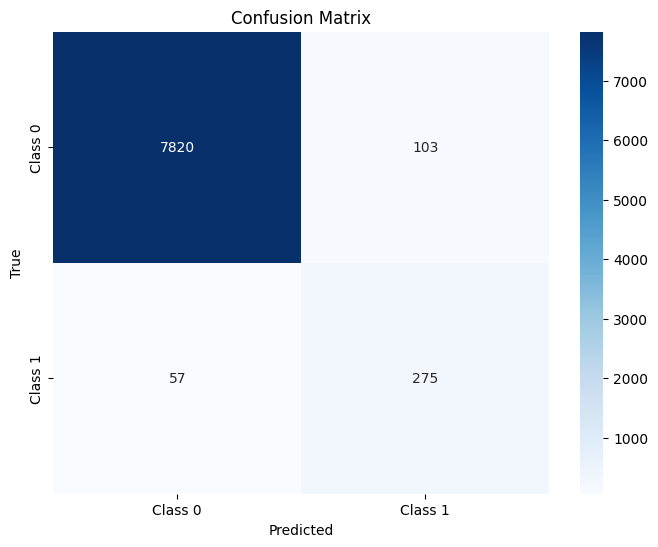

In [20]:
# Generate sequences from test_df
seq_gen_test = gen_sequence_bin_lstm(test_df, sequence_length, sequence_cols)
seq_array_test = np.array(seq_gen_test).astype(np.float32)

# Predict labels using the trained model
predictions_label1 = model2_LSTM_binary.predict(seq_array_test, batch_size=200)
predictions_label1 = (predictions_label1 > 0.5).astype(int).flatten()

# Generate matching id and cycle arrays
ids = []
cycles = []
for _, group in test_df.groupby('id'):
    for start in range(len(group) - sequence_length + 1):
        ids.append(group['id'].iloc[start])
        cycles.append(group['cycle'].iloc[start + sequence_length - 1])

# Convert to numpy arrays
ids = np.array(ids)
cycles = np.array(cycles)
label1_values = get_label1_values(test_df, sequence_length)

# Ensure all lengths match
num_test_sequences = len(predictions_label1)
assert len(ids) == num_test_sequences, "Length mismatch for 'id'"
assert len(cycles) == num_test_sequences, "Length mismatch for 'cycle'"
assert len(label1_values) == num_test_sequences, "Length mismatch for 'label1'"

# Create output DataFrame
output_df_model2_LSTM_binary = pd.DataFrame({
    'id': ids,
    'cycle': cycles,
    'predicted_label1': predictions_label1,

})

print(output_df_model2_LSTM_binary.head())

evaluate_model_confusiontabulate(label1_values, predictions_label1)

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 70)         │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50, 70)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 45)             │        20,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,806 (186.74 KB)

 Trainable params: 47,806 (186.74 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8334 - loss: 0.3883 - val_accuracy: 0.9476 - val_loss: 0.1164
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9578 - loss: 0.1075 - val_accuracy: 0.9373 - val_loss: 0.1264
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9359 - loss: 0.1622
Accurracy: 0.9341692924499512
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step

Metrics:
+-----------+----------+
| Metric    |    Score |
+===========+==========+
| Accuracy  | 0.934169 |
+-----------+----------+
| Precision | 0.998556 |
+-----------+----------+
| Recall    | 0.669032 |
+-----------+----------+
| F1 Score  | 0.801236 |
+-----------+----------+


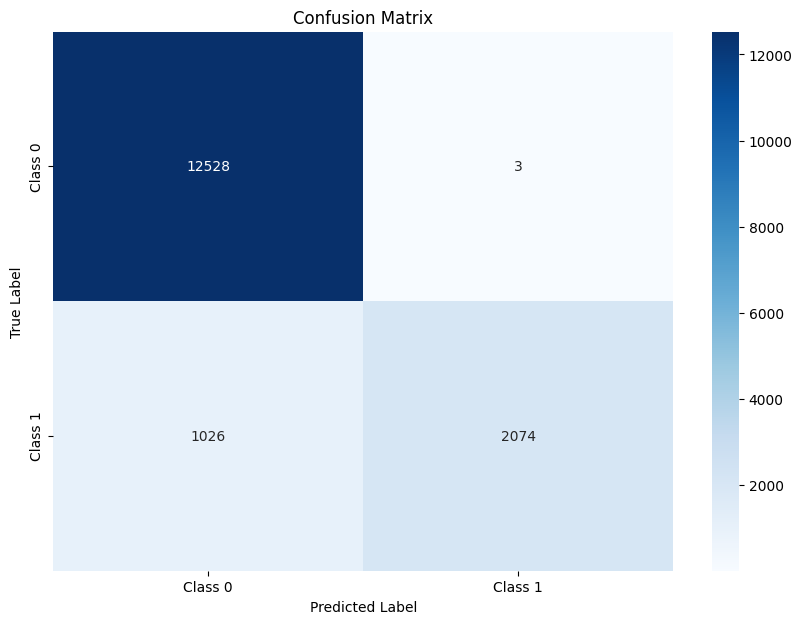

In [21]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
lstm_units_1 = 70
lstm_units_2 = 45
dropout_rate = 0.2
optimizer_name = 'adam'
model3_LSTM_binary = build_lstm_network(sequence_length, nb_features, nb_out, lstm_units_1, lstm_units_2, dropout_rate, optimizer_name)
print(model3_LSTM_binary.summary())

model3_LSTM_binary.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

scores_model3_lstm = model3_LSTM_binary.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores_model3_lstm[1]))
plot_confusion_matrix(model3_LSTM_binary, seq_array, label_array, verbose=1, batch_size=200)

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
   id  cycle  predicted_label1
0   3     50                 0
1   3     51                 0
2   3     52                 0
3   3     53                 0
4   3     54                 0

Classification Report:
+--------------+--------------------+--------------------+--------------------+--------------------+
|              |     precision      |       recall       |      f1-score      |      support       |
+--------------+--------------------+--------------------+--------------------+--------------------+
|   Class 0    | 0.9746492739355156 | 0.9996213555471413 | 0.9869773817683345 |       7923.0       |
|   Class 1    | 0.9767441860465116 | 0.3795180722891566 | 0.5466377440347071 |       332.0        |
|   accuracy   | 0.9746820109024833 | 0.9746820109024833 | 0.9746820109024833 | 0.9746820109024833 |
|  macro avg   | 0.9756967299910135 | 0.6895697139181489 | 0.7668075629015207 |       8255.0       |
| weighted avg | 0.9747335272148433 | 0.974

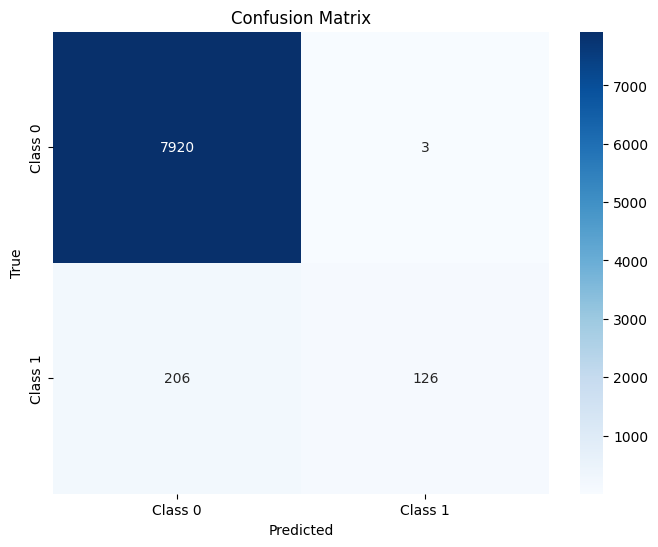

In [22]:
# Generate sequences from test_df
seq_gen_test = gen_sequence_bin_lstm(test_df, sequence_length, sequence_cols)
seq_array_test = np.array(seq_gen_test).astype(np.float32)

# Predict labels using the trained model
predictions_label1 = model3_LSTM_binary.predict(seq_array_test, batch_size=200)
predictions_label1 = (predictions_label1 > 0.5).astype(int).flatten()

# Generate matching id and cycle arrays
ids = []
cycles = []
for _, group in test_df.groupby('id'):
    for start in range(len(group) - sequence_length + 1):
        ids.append(group['id'].iloc[start])
        cycles.append(group['cycle'].iloc[start + sequence_length - 1])

# Convert to numpy arrays
ids = np.array(ids)
cycles = np.array(cycles)
label1_values = get_label1_values(test_df, sequence_length)

# Ensure all lengths match
num_test_sequences = len(predictions_label1)
assert len(ids) == num_test_sequences, "Length mismatch for 'id'"
assert len(cycles) == num_test_sequences, "Length mismatch for 'cycle'"
assert len(label1_values) == num_test_sequences, "Length mismatch for 'label1'"

# Create output DataFrame
output_df_model3_LSTM_binary = pd.DataFrame({
    'id': ids,
    'cycle': cycles,
    'predicted_label1': predictions_label1,

})

print(output_df_model3_LSTM_binary.head())

evaluate_model_confusiontabulate(label1_values, predictions_label1)

In [23]:
def cross_validate_model(model_builder, seq_array, label_array, n_splits=5, epochs=10, batch_size=200, verbose=0):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, val_index in kf.split(seq_array):
        X_train, X_val = seq_array[train_index], seq_array[val_index]
        y_train, y_val = label_array[train_index], label_array[val_index]

        # Build the model
        model = model_builder()
        
        # Fit the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,
                  validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=verbose)])
        
        # Evaluate the model
        y_val_pred = model.predict(X_val, batch_size=batch_size)
        y_val_pred = (y_val_pred > 0.5).astype(int).flatten()  # Binary classification
        y_val_true = y_val.flatten()

        accuracy = accuracy_score(y_val_true, y_val_pred)
        accuracies.append(accuracy)
    
    return accuracies
def build_model1():
    return build_lstm_network(sequence_length, nb_features, nb_out, lstm_units_1=100, lstm_units_2=75, dropout_rate=0.15, optimizer_name='adam')

def build_model2():
    # Replace with actual parameters for model2
    return build_lstm_network(sequence_length, nb_features, nb_out, lstm_units_1=80, lstm_units_2=60, dropout_rate=0.1, optimizer_name='adam')

def build_model3():
    return build_lstm_network(sequence_length, nb_features, nb_out, lstm_units_1=70, lstm_units_2=45, dropout_rate=0.2, optimizer_name='adam')

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.8100 - loss: 0.3790 - val_accuracy: 0.9466 - val_loss: 0.1271
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9533 - loss: 0.1194 - val_accuracy: 0.9674 - val_loss: 0.0756
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9677 - loss: 0.0809 - val_accuracy: 0.9674 - val_loss: 0.0898
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.9701 - loss: 0.0748 - val_accuracy: 0.9674 - val_loss: 0.0727
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9662 - loss: 0.0787 - val_accuracy: 0.9709 - val_loss: 0.0631
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.9694 - loss: 0.0677 - val_accuracy: 0.9719 - val_loss: 0.0632
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9759 - loss: 0.0594 - val_accuracy: 0.9738 - val_loss: 0.0586
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.9706 - loss: 0.0673 - val_accuracy: 0

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.7957 - loss: 0.4033 - val_accuracy: 0.9399 - val_loss: 0.1538
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9521 - loss: 0.1220 - val_accuracy: 0.9674 - val_loss: 0.0795
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9678 - loss: 0.0809 - val_accuracy: 0.9696 - val_loss: 0.0774
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9724 - loss: 0.0680 - val_accuracy: 0.9718 - val_loss: 0.0696
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9697 - loss: 0.0716 - val_accuracy: 0.9632 - val_loss: 0.0765
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9705 - loss: 0.0695 - val_accuracy: 0.9789 - val_loss: 0.0625
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9754 - loss: 0.0616 - val_accuracy: 0.9738 - val_loss: 0.0644
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9738 - loss: 0.0617 - val_accuracy: 0.9766 - val_

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.8580 - loss: 0.3554 - val_accuracy: 0.9661 - val_loss: 0.0965
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9549 - loss: 0.1105 - val_accuracy: 0.9699 - val_loss: 0.0767
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9552 - loss: 0.1077 - val_accuracy: 0.9750 - val_loss: 0.0687
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9698 - loss: 0.0724 - val_accuracy: 0.9578 - val_loss: 0.1000
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9657 - loss: 0.0817 - val_accuracy: 0.9731 - val_loss: 0.0731
Epoch 5: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.7951 - loss: 0.4091 - val_accuracy: 0.9571 - val_loss: 0.1092
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.9572 - loss: 0.1047 - val_accuracy: 0.9600 - val_loss: 0.0925
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9669 - loss: 0.0841 - val_accuracy: 0.9734 - val_loss: 0.0665
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.9658 - loss: 0.0794 - val_accuracy: 0.9725 - val_loss: 0.0681
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9736 - loss: 0.0621 - val_accuracy: 0.9680 - val_loss: 0.0746
Epoch 5: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.8348 - loss: 0.3880 - val_accuracy: 0.9402 - val_loss: 0.1438
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9580 - loss: 0.0996 - val_accuracy: 0.9594 - val_loss: 0.1025
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9574 - loss: 0.1015 - val_accuracy: 0.9766 - val_loss: 0.0684
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9706 - loss: 0.0729 - val_accuracy: 0.9699 - val_loss: 0.0748
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.9674 - loss: 0.0805 - val_accuracy: 0.9766 - val_loss: 0.0610
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.9709 - loss: 0.0632 - val_accuracy: 0.9754 - val_loss: 0.0609
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9649 - loss: 0.0793 - val_accuracy: 0.9754 - val_loss: 0.0549
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.9703 - loss: 0.0695 - val_accuracy: 0.9770 - val_

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.8464 - loss: 0.3755 - val_accuracy: 0.9555 - val_loss: 0.1255
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9480 - loss: 0.1201 - val_accuracy: 0.9546 - val_loss: 0.1149
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9645 - loss: 0.0883 - val_accuracy: 0.9722 - val_loss: 0.0621
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9703 - loss: 0.0695 - val_accuracy: 0.9728 - val_loss: 0.0619
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9730 - loss: 0.0659 - val_accuracy: 0.9591 - val_loss: 0.0858
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9726 - loss: 0.0669 - val_accuracy: 0.9776 - val_loss: 0.0519
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9762 - loss: 0.0565 - val_accuracy: 0.9664 - val_loss: 0.0761
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9754 - loss: 0.0580 - val_accuracy: 0.9709 - val_loss: 0.

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7805 - loss: 0.4528 - val_accuracy: 0.9383 - val_loss: 0.1672
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9492 - loss: 0.1283 - val_accuracy: 0.9578 - val_loss: 0.0970
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9635 - loss: 0.0887 - val_accuracy: 0.9546 - val_loss: 0.1109
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9552 - loss: 0.1033 - val_accuracy: 0.9658 - val_loss: 0.0795
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9717 - loss: 0.0721 - val_accuracy: 0.9699 - val_loss: 0.0715
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9665 - loss: 0.0779 - val_accuracy: 0.9776 - val_loss: 0.0523
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9769 - loss: 0.0546 - val_accuracy: 0.9805 - val_loss: 0.0495
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9773 - loss: 0.0557 - val_accuracy: 0.9757 - val_loss: 0.

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8134 - loss: 0.3922 - val_accuracy: 0.9223 - val_loss: 0.1709
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9501 - loss: 0.1239 - val_accuracy: 0.9440 - val_loss: 0.1268
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9560 - loss: 0.1039 - val_accuracy: 0.9699 - val_loss: 0.0765
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9724 - loss: 0.0691 - val_accuracy: 0.9648 - val_loss: 0.0893
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9743 - loss: 0.0615 - val_accuracy: 0.9581 - val_loss: 0.0933
Epoch 5: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8273 - loss: 0.4089 - val_accuracy: 0.9431 - val_loss: 0.1422
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9503 - loss: 0.1188 - val_accuracy: 0.9543 - val_loss: 0.1018
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9533 - loss: 0.1124 - val_accuracy: 0.9738 - val_loss: 0.0659
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9712 - loss: 0.0699 - val_accuracy: 0.9648 - val_loss: 0.0794
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9714 - loss: 0.0710 - val_accuracy: 0.9770 - val_loss: 0.0535
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9746 - loss: 0.0610 - val_accuracy: 0.9629 - val_loss: 0.0753
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.9723 - loss: 0.0625 - val_accuracy: 0.9763 - val_loss: 0.0656
Epoch 7: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.8514 - loss: 0.3729 - val_accuracy: 0.9456 - val_loss: 0.1418
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9514 - loss: 0.1261 - val_accuracy: 0.9562 - val_loss: 0.1035
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9587 - loss: 0.0967 - val_accuracy: 0.9594 - val_loss: 0.1010
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9680 - loss: 0.0774 - val_accuracy: 0.9715 - val_loss: 0.0764
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9728 - loss: 0.0652 - val_accuracy: 0.9690 - val_loss: 0.0668
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9676 - loss: 0.0720 - val_accuracy: 0.9664 - val_loss: 0.0753
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9736 - loss: 0.0649 - val_accuracy: 0.9725 - val_loss: 0.0690
Epoch 7: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8272 - loss: 0.4344 - val_accuracy: 0.9402 - val_loss: 0.1454
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.9507 - loss: 0.1217 - val_accuracy: 0.9696 - val_loss: 0.0743
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9550 - loss: 0.1026 - val_accuracy: 0.9722 - val_loss: 0.0689
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9706 - loss: 0.0695 - val_accuracy: 0.9584 - val_loss: 0.0971
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9738 - loss: 0.0692 - val_accuracy: 0.9690 - val_loss: 0.0696
Epoch 5: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.7991 - loss: 0.4448 - val_accuracy: 0.9338 - val_loss: 0.1591
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9508 - loss: 0.1256 - val_accuracy: 0.9683 - val_loss: 0.0835
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9649 - loss: 0.0863 - val_accuracy: 0.9392 - val_loss: 0.1405
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9652 - loss: 0.0892 - val_accuracy: 0.9741 - val_loss: 0.0652
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9692 - loss: 0.0728 - val_accuracy: 0.9738 - val_loss: 0.0609
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9692 - loss: 0.0709 - val_accuracy: 0.9747 - val_loss: 0.0608
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.9743 - loss: 0.0630 - val_accuracy: 0.9773 - val_loss: 0.0609
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.9796 - loss: 0.0515 - val_accuracy: 0.9677 - val_loss: 0.

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.8485 - loss: 0.3893 - val_accuracy: 0.9450 - val_loss: 0.1413
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9548 - loss: 0.1168 - val_accuracy: 0.9623 - val_loss: 0.0889
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9611 - loss: 0.0960 - val_accuracy: 0.9734 - val_loss: 0.0684
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9689 - loss: 0.0748 - val_accuracy: 0.9511 - val_loss: 0.1106
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9616 - loss: 0.0904 - val_accuracy: 0.9782 - val_loss: 0.0572
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9748 - loss: 0.0648 - val_accuracy: 0.9744 - val_loss: 0.0592
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9609 - loss: 0.0885 - val_accuracy: 0.9776 - val_loss: 0.0546
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9755 - loss: 0.0585 - val_accuracy: 0.9741 - val_loss: 0.

c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8390 - loss: 0.3999 - val_accuracy: 0.9568 - val_loss: 0.1176
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2419s 39s/step - accuracy: 0.9581 - loss: 0.1085 - val_accuracy: 0.9671 - val_loss: 0.0796
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9660 - loss: 0.0800 - val_accuracy: 0.9782 - val_loss: 0.0618
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.9707 - loss: 0.0723 - val_accuracy: 0.9798 - val_loss: 0.0560
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.9729 - loss: 0.0676 - val_accuracy: 0.9763 - val_loss: 0.0612
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9740 - loss: 0.0622 - val_accuracy: 0.9664 - val_loss: 0.0698
Epoch 6: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Epoch 1/10


c:\Users\daric\OneDrive\Desktop\TFM\tfm_predictive_maintenance\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - accuracy: 0.8261 - loss: 0.3843 - val_accuracy: 0.9450 - val_loss: 0.1255
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9488 - loss: 0.1214 - val_accuracy: 0.9690 - val_loss: 0.0786
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9657 - loss: 0.0828 - val_accuracy: 0.9514 - val_loss: 0.1170
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9566 - loss: 0.1028 - val_accuracy: 0.9671 - val_loss: 0.0720
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9710 - loss: 0.0699 - val_accuracy: 0.9773 - val_loss: 0.0575
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9722 - loss: 0.0647 - val_accuracy: 0.9757 - val_loss: 0.0700
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9719 - loss: 0.0709 - val_accuracy: 0.9738 - val_loss: 0.0639
Epoch 7: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


C:\Users\daric\AppData\Local\Temp\ipykernel_9732\2773732552.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




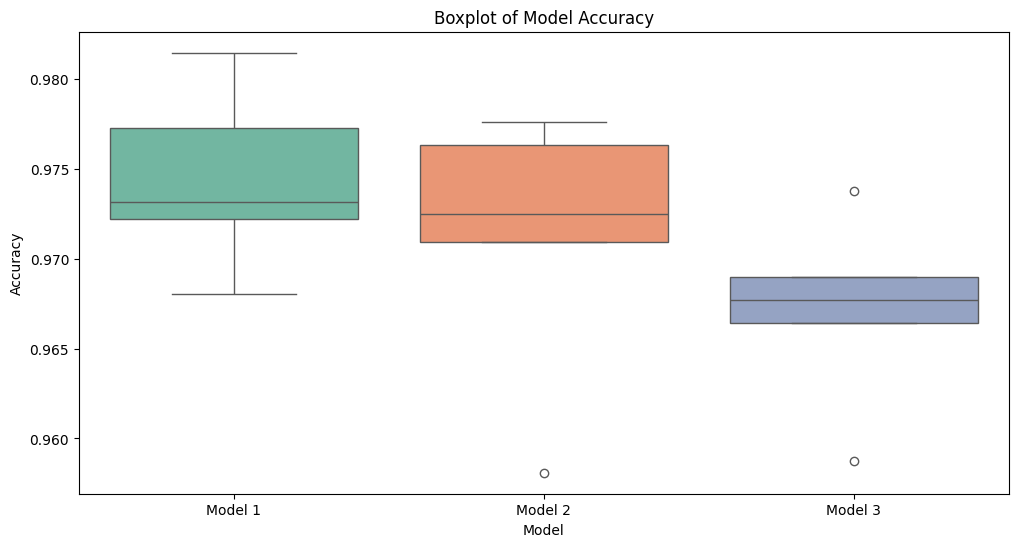

In [24]:

# Collect accuracies for each model
accuracies_model1_lstm_binary = cross_validate_model(build_model1, seq_array, label_array, n_splits=5, epochs=10, batch_size=200, verbose=1)
accuracies_model2_lstm_binary = cross_validate_model(build_model2, seq_array, label_array, n_splits=5, epochs=10, batch_size=200, verbose=1)
accuracies_model3_lstm_binary = cross_validate_model(build_model3, seq_array, label_array, n_splits=5, epochs=10, batch_size=200, verbose=1)

# Prepare data for plotting
results_df = pd.DataFrame({
    'Model': ['Model 1'] * len(accuracies_model1_lstm_binary) +
             ['Model 2'] * len(accuracies_model2_lstm_binary) +
             ['Model 3'] * len(accuracies_model3_lstm_binary),
    'Accuracy': accuracies_model1_lstm_binary + accuracies_model2_lstm_binary + accuracies_model3_lstm_binary
})

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model', y='Accuracy', data=results_df, palette='Set2')
plt.title('Boxplot of Model Accuracy')
plt.show()

# Random Forest Network for linear regresor

In [25]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [26]:
sequence_cols = [
    'setting1', 'setting2', 'setting3', 'cycle_norm',
    's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
    's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17',
    's18', 's19', 's20', 's21'
]

# Extract features and target from the DataFrame
X = train_df[sequence_cols]
y = train_df['RUL']

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the entire dataset
rf_regressor.fit(X, y)

# Make predictions on the same dataset
y_pred = rf_regressor.predict(X)

# Calculate performance metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Create a DataFrame for results
result_df_rf_linear_regressor = pd.DataFrame({
    'Actual_RUL': y,
    'Predicted_RUL': y_pred
})


Mean Absolute Error: 9.3790935970142
Mean Squared Error: 181.97871396442247


- Now lets test the RF regressor into our test_df

Mean Absolute Error: 31.679328039095907
Mean Squared Error: 1723.1982241905923


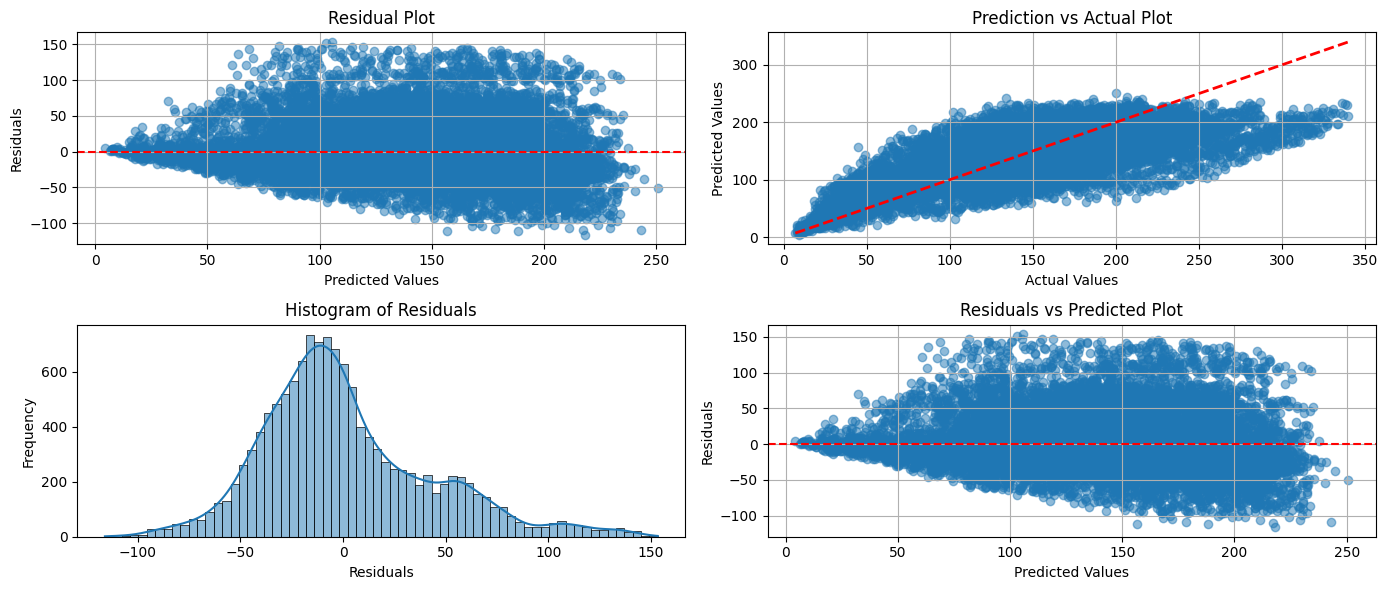

Mean Absolute Error (for RUL < 30): 11.115830618892508
Mean Squared Error (for RUL < 30): 287.3369719869707


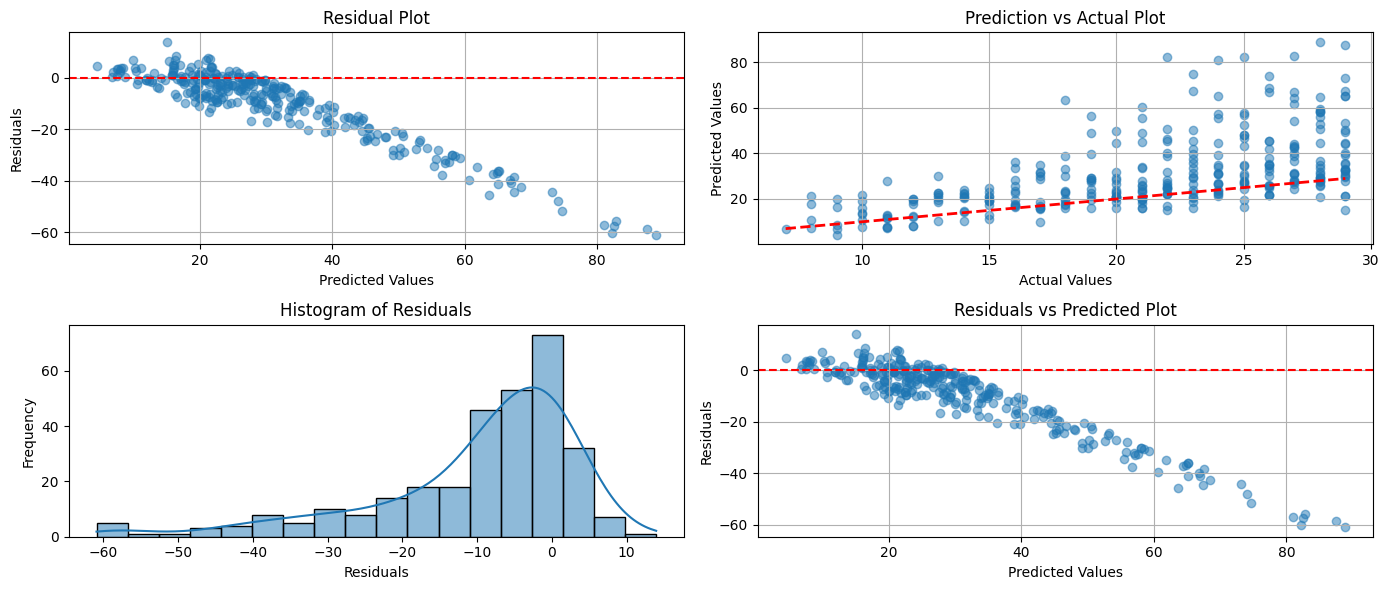

In [27]:
# Ensure you're using the correct DataFrame and features for predictions
X_test_rf_reg = test_df[sequence_cols]
y_test_rf_reg = test_df['RUL']

# Make predictions on the test dataset
y_pred = rf_regressor.predict(X_test_rf_reg)

# Calculate performance metrics
mae = mean_absolute_error(y_test_rf_reg, y_pred)
mse = mean_squared_error(y_test_rf_reg, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Create a DataFrame for results
result_df_rf_linear_regressor = pd.DataFrame({
    'Actual_RUL': y_test_rf_reg,
    'Predicted_RUL': y_pred
})

# Plot performance
plot_regression_performance(y_test_rf_reg, y_pred)

evaluate_rul_performance(y_test_rf_reg, y_pred, threshold=30)

# Random Forest Network for multiclass classification

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     17531
     Class 1       1.00      1.00      1.00      1500
     Class 2       1.00      1.00      1.00      1600

    accuracy                           1.00     20631
   macro avg       1.00      1.00      1.00     20631
weighted avg       1.00      1.00      1.00     20631

   Actual_Label2  Predicted_Label2
0              0                 0
1              0                 0
2              0                 0
3              0                 0
4              0                 0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     17531
     Class 1       1.00      1.00      1.00      1500
     Class 2       1.00      1.00      1.00      1600

    accuracy                           1.00     20631
   macro avg       1.00      1.00      1.00     20631
weighted 

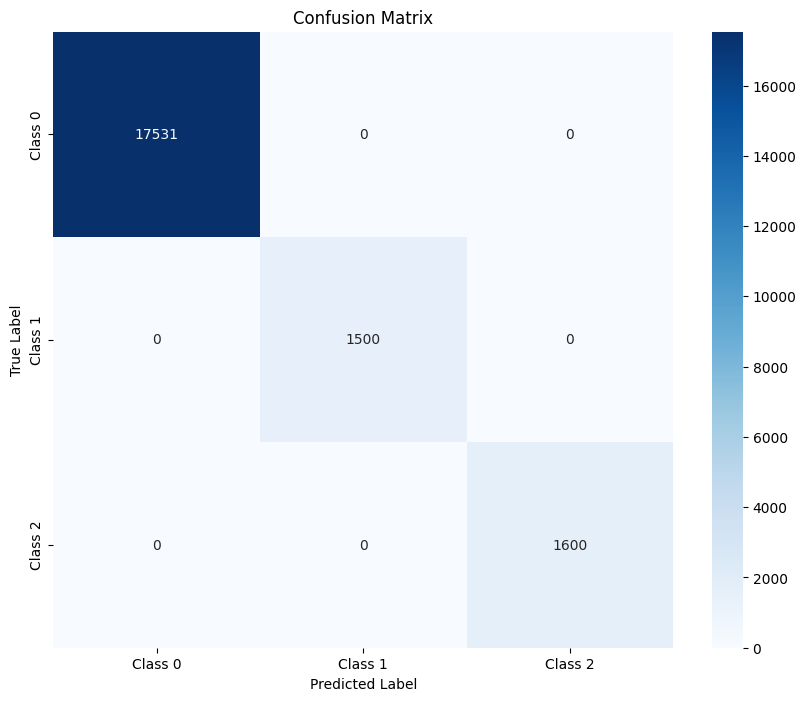

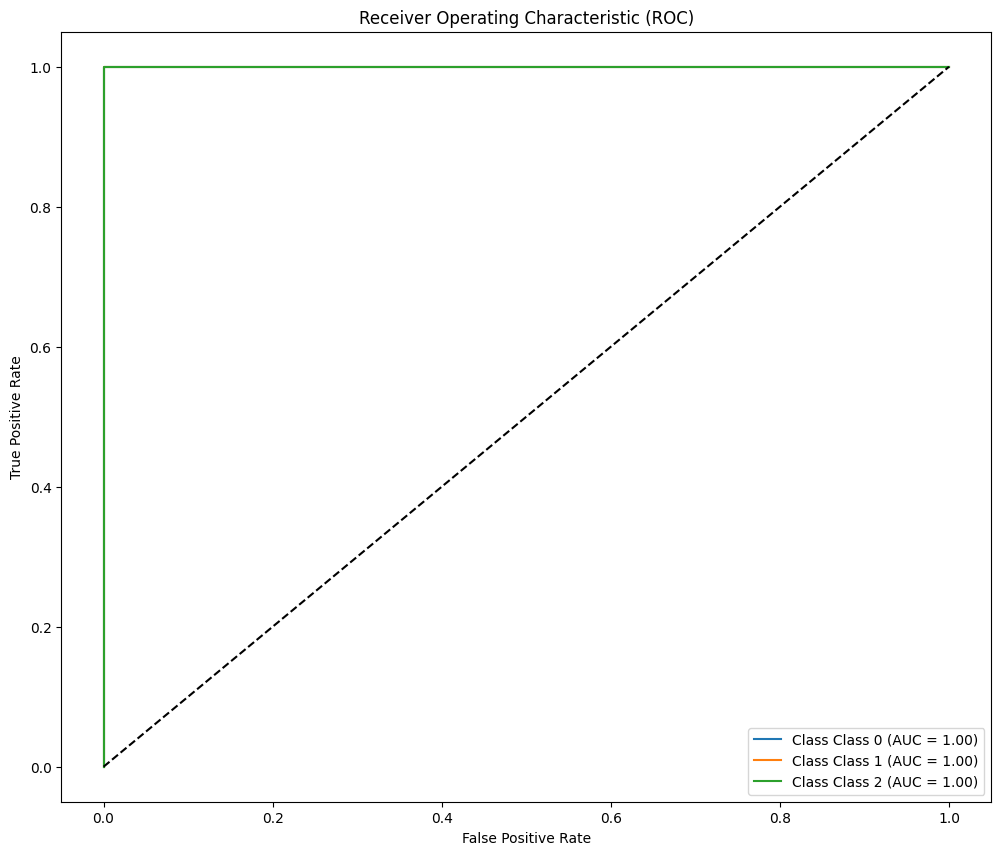

In [28]:
# Extract features and target from the DataFrame
X = train_df[sequence_cols]
y = train_df['label2']  # Target variable for classification

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the entire dataset
rf_classifier.fit(X, y)

y_pred = rf_classifier.predict(X)

# Evaluate the model's performance
accuracy = accuracy_score(y, y_pred)
classification_rep = classification_report(y, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

result_df_rf_classifier = pd.DataFrame({
    'Actual_Label2': y,
    'Predicted_Label2': y_pred
})

# Display the first few rows of the result DataFrame
print(result_df_rf_classifier.head())


classes = ['Class 0', 'Class 1', 'Class 2']
evaluate_RF_MULTICLASS(y, y_pred, classes)



Classification Report:
+--------------+--------------------+---------------------+--------------------+--------------------+
|              |     precision      |       recall        |      f1-score      |      support       |
+--------------+--------------------+---------------------+--------------------+--------------------+
|   Class 0    | 0.9895752295005446 |  0.996552804763397  | 0.9930517604809118 |      12764.0       |
|   Class 1    | 0.6613756613756614 | 0.45955882352941174 | 0.5422993492407809 |       272.0        |
|   Class 2    | 0.6792452830188679 |         0.6         | 0.6371681415929203 |        60.0        |
|   accuracy   | 0.9835827733659133 | 0.9835827733659133  | 0.9835827733659133 | 0.9835827733659133 |
|  macro avg   | 0.7767320579650246 | 0.6853705427642697  | 0.7241730837715377 |      13096.0       |
| weighted avg | 0.9813368300412539 | 0.9835827733659133  | 0.9820592686520636 |      13096.0       |
+--------------+--------------------+---------------------+

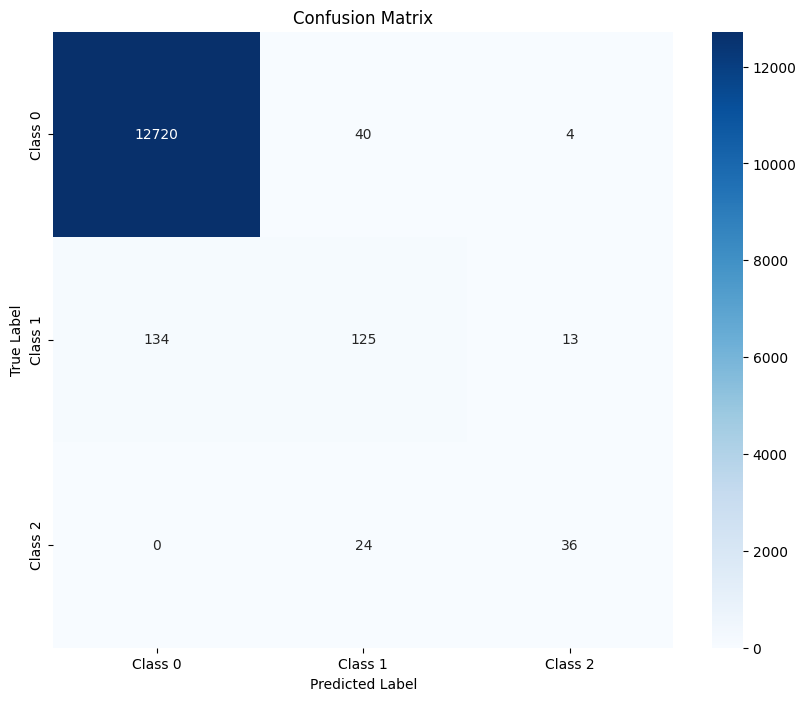

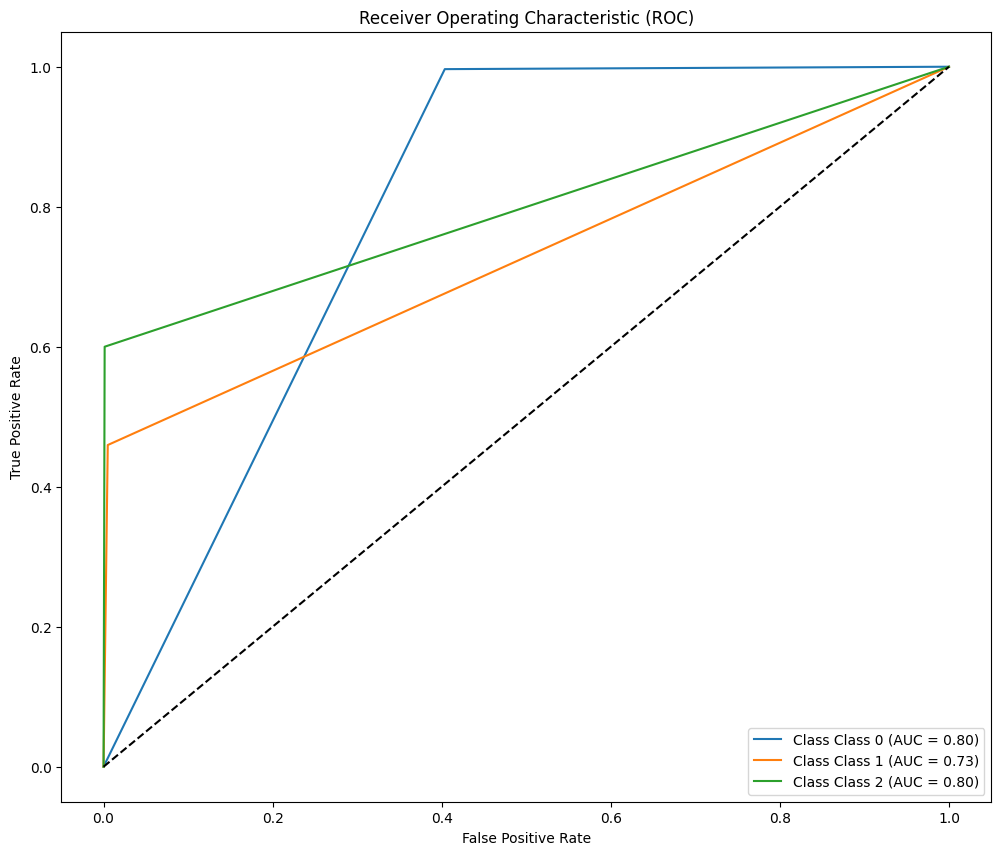

In [29]:
# Extract features and actual labels from the test DataFrame
X_test = test_df[sequence_cols]
y_test = test_df['label2']

# Make predictions on the test dataset
y_pred = rf_classifier.predict(X_test)

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'], output_dict=True)

# Convert the classification report to a DataFrame for tabular representation
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Create a summary DataFrame with accuracy
summary_df = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Score': [accuracy]
})

# Convert DataFrames to tabulate format
classification_rep_table = tabulate(classification_rep_df, headers='keys', tablefmt='pretty')
summary_table = tabulate(summary_df, headers='keys', tablefmt='pretty')

# Print results
print("Classification Report:")
print(classification_rep_table)

print("\nSummary:")
print(summary_table)


classes = ['Class 0', 'Class 1', 'Class 2']
evaluate_RF_MULTICLASS(y_test, y_pred, classes)

The multiclass RF is obviously overfitted that is why we will use an algorithim called smote for the umbalanced classes . To handle class imbalance in your classification problem, you can use SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic samples for the minority classes. SMOTE is particularly useful for balancing datasets where one class is underrepresented.

Here’s how you can integrate SMOTE into your workflow to handle the imbalance in your dataset:

Apply SMOTE to the Training Data: Before training your Random Forest model, apply SMOTE to balance the class distribution in the training dataset.

Train the Random Forest Classifier: Use the balanced training data to fit your model.

Evaluate the Model: Use the evaluate_RF_MULTICLASS function to assess the model's performance on the test data.

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     17531
     Class 1       1.00      1.00      1.00      1500
     Class 2       1.00      1.00      1.00      1600

    accuracy                           1.00     20631
   macro avg       1.00      1.00      1.00     20631
weighted avg       1.00      1.00      1.00     20631

   Actual_Label2  Predicted_Label2
0              0                 0
1              0                 0
2              0                 0
3              0                 0
4              0                 0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     17531
     Class 1       1.00      1.00      1.00      1500
     Class 2       1.00      1.00      1.00      1600

    accuracy                           1.00     20631
   macro avg       1.00      1.00      1.00     20631
weighted 

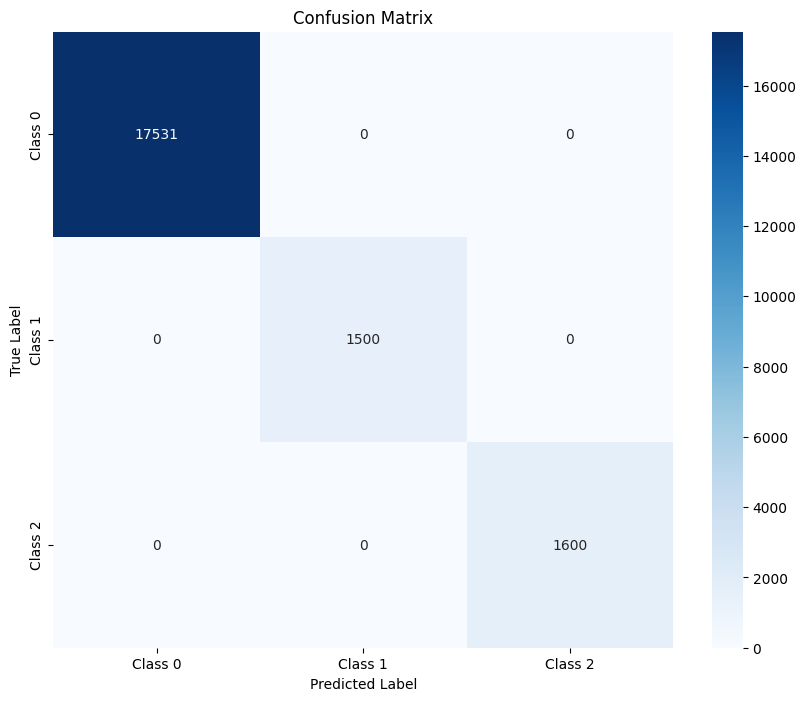

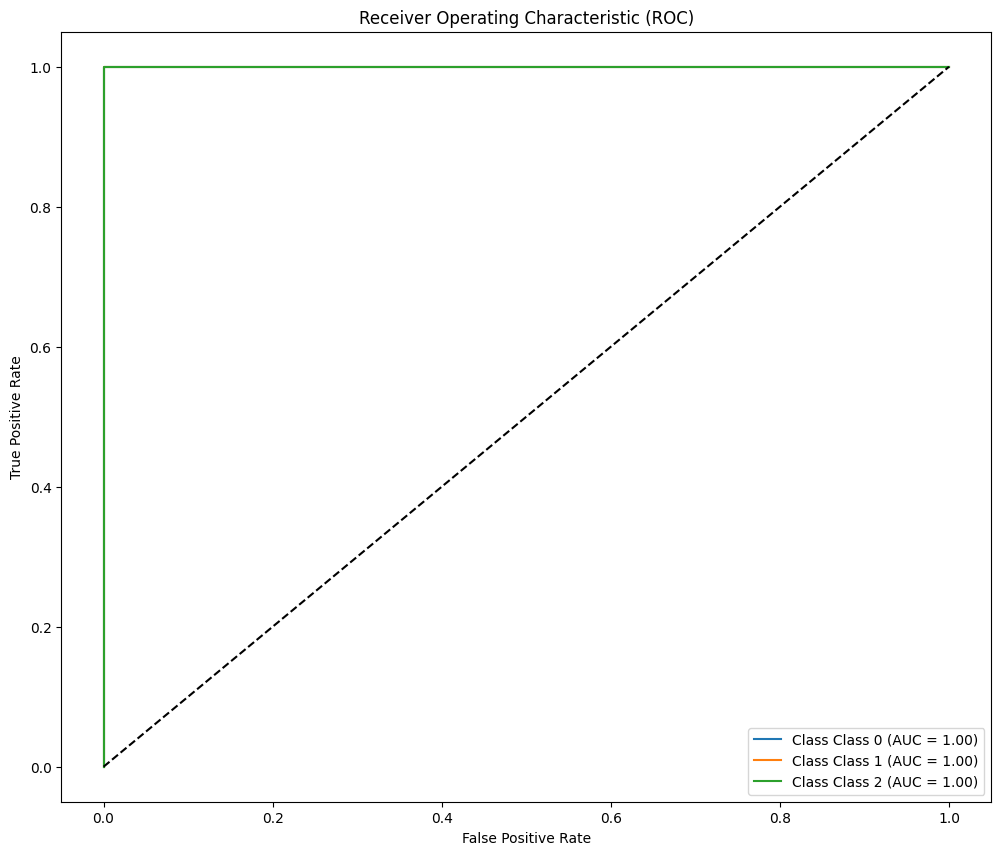

In [30]:
X_train = train_df[sequence_cols]
y_train = train_df['label2']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest Classifier
rf_classifier_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_smote.fit(X_train_balanced, y_train_balanced)

y_pred = rf_classifier_smote.predict(X_train)

# Evaluate the model's performance
accuracy = accuracy_score(y_train, y_pred)
classification_rep = classification_report(y_train, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

result_df_rf_classifier_smote = pd.DataFrame({
    'Actual_Label2': y_train,
    'Predicted_Label2': y_pred
})

# Display the first few rows of the result DataFrame
print(result_df_rf_classifier_smote.head())


classes = ['Class 0', 'Class 1', 'Class 2']
evaluate_RF_MULTICLASS(y_train, y_pred, classes)




Classification Report:
+--------------+---------------------+--------------------+--------------------+--------------------+
|              |      precision      |       recall       |      f1-score      |      support       |
+--------------+---------------------+--------------------+--------------------+--------------------+
|   Class 0    | 0.9945523448602558  | 0.9869163271701661 | 0.9907196224931184 |      12764.0       |
|   Class 1    | 0.49865229110512127 | 0.6801470588235294 | 0.5754276827371695 |       272.0        |
|   Class 2    | 0.6440677966101694  | 0.6333333333333333 | 0.6386554621848739 |        60.0        |
|   accuracy   | 0.9789248625534515  | 0.9789248625534515 | 0.9789248625534515 | 0.9789248625534515 |
|  macro avg   | 0.7124241441918487  | 0.7667989064423429 | 0.7349342558050539 |      13096.0       |
| weighted avg | 0.9826468861311474  | 0.9789248625534515 | 0.9804811330893225 |      13096.0       |
+--------------+---------------------+--------------------+

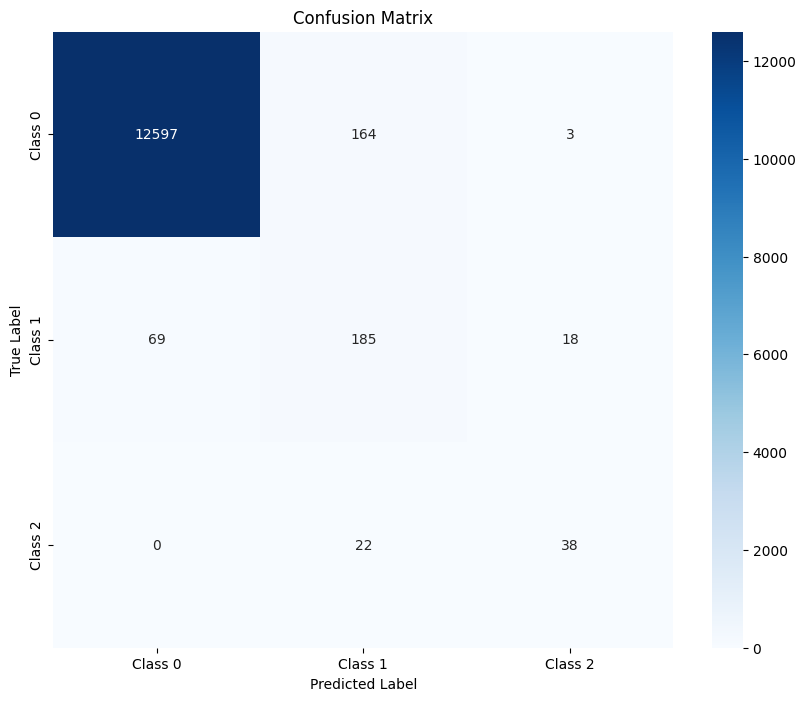

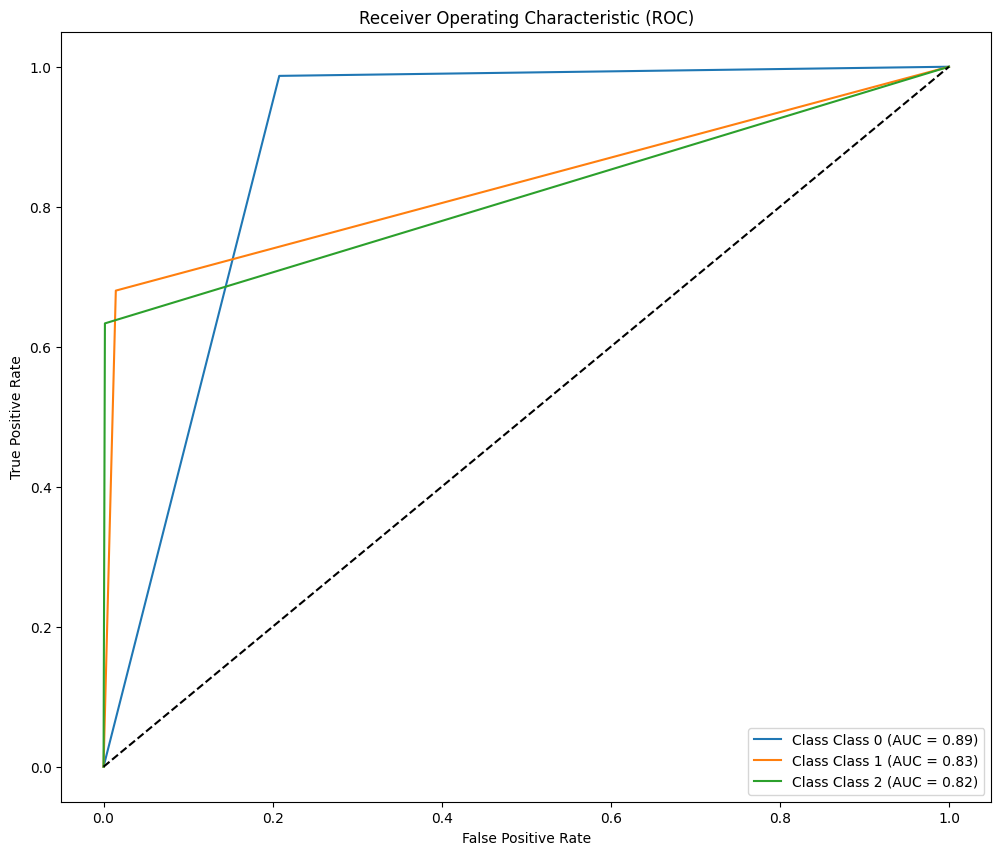

In [32]:
# Extract features and actual labels from the test DataFrame
X_test = test_df[sequence_cols]
y_test = test_df['label2']

# Make predictions on the test dataset
y_pred = rf_classifier_smote.predict(X_test)

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1', 'Class 2'], output_dict=True)

# Convert the classification report to a DataFrame for tabular representation
classification_rep_df = pd.DataFrame(classification_rep).transpose()

# Create a summary DataFrame with accuracy
summary_df = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Score': [accuracy]
})

# Convert DataFrames to tabulate format
classification_rep_table = tabulate(classification_rep_df, headers='keys', tablefmt='pretty')
summary_table = tabulate(summary_df, headers='keys', tablefmt='pretty')

# Print results
print("Classification Report:")
print(classification_rep_table)

print("\nSummary:")
print(summary_table)


classes = ['Class 0', 'Class 1', 'Class 2']
evaluate_RF_MULTICLASS(y_test, y_pred, classes)

# RANDOM FOREST FOR BINARY
Now lets use a random forest, the best and most used for binary clasification

+-----------+-------+
|  Metric   | Score |
+-----------+-------+
| Accuracy  |  1.0  |
| Precision |  1.0  |
|  Recall   |  1.0  |
| F1 Score  |  1.0  |
+-----------+-------+


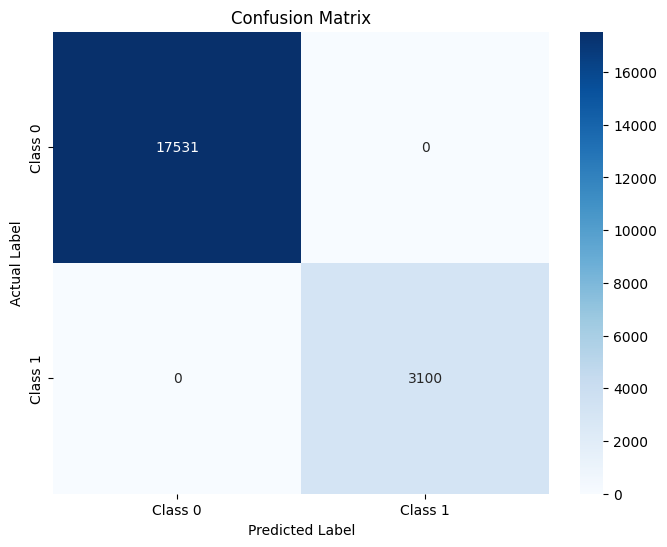

   Actual_Label1  Predicted_Label1
0              0                 0
1              0                 0
2              0                 0
3              0                 0
4              0                 0
+-----------+-------+
|  Metric   | Score |
+-----------+-------+
| Accuracy  |  1.0  |
| Precision |  1.0  |
|  Recall   |  1.0  |
| F1 Score  |  1.0  |
+-----------+-------+


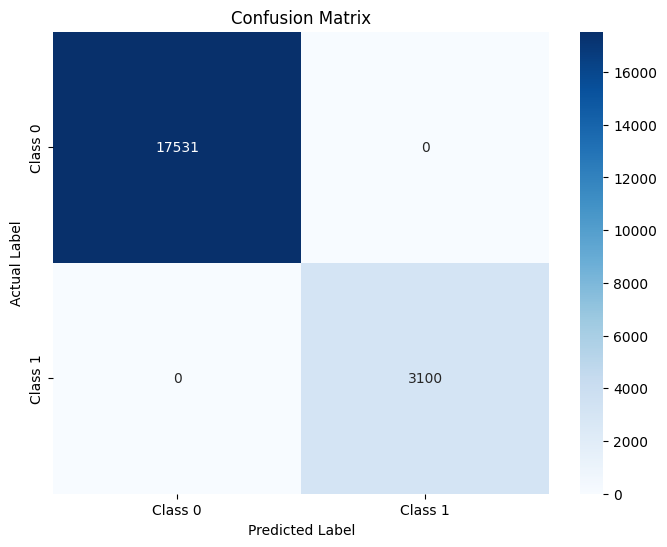

In [13]:
def evaluate_binary_rf(y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Print metrics using tabulate
    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [accuracy, precision, recall, f1]
    }
    print(tabulate(metrics, headers='keys', tablefmt='pretty'))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

X_train = train_df[sequence_cols]
y_train = train_df['label1']

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize and train the Random Forest Classifier
rf_binary_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary_smote.fit(X_train_balanced, y_train_balanced)

# Predict on the training set (or use a separate validation/test set)
y_pred = rf_binary_smote.predict(X_train)

# Evaluate the model's performance using the custom function
evaluate_binary_rf(y_train, y_pred)

# Create a DataFrame with actual and predicted labels
result_df_rf_binary_smote = pd.DataFrame({
    'Actual_Label1': y_train,
    'Predicted_Label1': y_pred
})

# Display the first few rows of the result DataFrame
print(result_df_rf_binary_smote.head())

def evaluate_binary_rf(y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Print metrics using tabulate
    metrics = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Score': [accuracy, precision, recall, f1]
    }
    print(tabulate(metrics, headers='keys', tablefmt='pretty'))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], 
                yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage with your data
evaluate_binary_rf(y_train, y_pred)


+-----------+--------------------+
|  Metric   |       Score        |
+-----------+--------------------+
| Accuracy  | 0.9842700061087355 |
| Precision | 0.6730769230769231 |
|  Recall   | 0.7379518072289156 |
| F1 Score  | 0.7040229885057471 |
+-----------+--------------------+


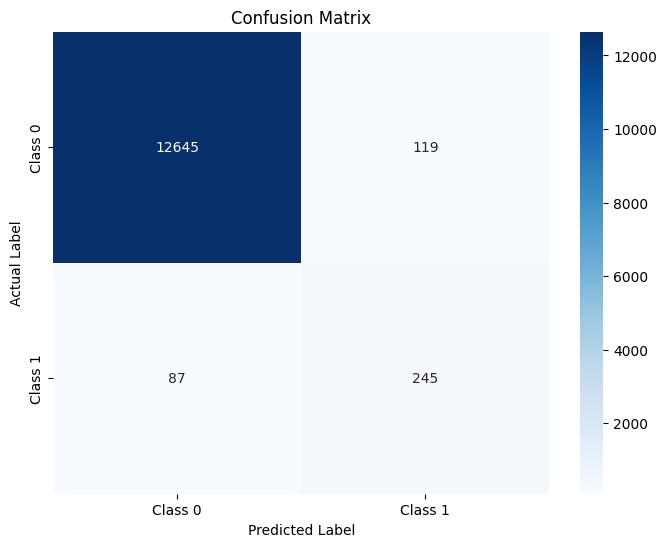

+-----------+--------------------+
|  Metric   |       Score        |
+-----------+--------------------+
| Accuracy  | 0.9842700061087355 |
| Precision | 0.6730769230769231 |
|  Recall   | 0.7379518072289156 |
| F1 Score  | 0.7040229885057471 |
+-----------+--------------------+


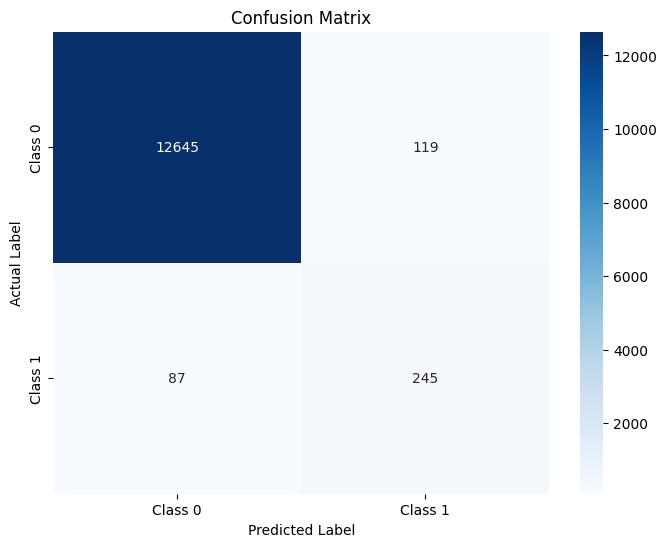

In [14]:

X_test = test_df[sequence_cols]
y_test = test_df['label1']


# Predict on the training set (or use a separate validation/test set)
y_pred = rf_binary_smote.predict(X_test)

# Evaluate the model's performance using the custom function
evaluate_binary_rf(y_test, y_pred)

# Create a DataFrame with actual and predicted labels
result_df_rf_binary_smote = pd.DataFrame({
    'Actual_Label1': y_test,
    'Predicted_Label1': y_pred
})

# Example usage with your data
evaluate_binary_rf(y_test, y_pred)

Lets save our best models

In [27]:
models_dir = 'C:/Users/daric/OneDrive/Desktop/tfm_v2/models'

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# Paths for saving models
model3_path = os.path.join(models_dir, 'model3_lstm_RUL.keras')
rf_binarymodel_path = os.path.join(models_dir, 'model_rf_binary_smote.joblib')
rf_model_path = os.path.join(models_dir, 'model_rf_multi_smote.joblib')

# Save Keras model (ensure model3_lstm_RUL is your Keras model)
try:
    model3_lstm_RUL.save(model3_path)
    print(f"model3_lstm_RUL saved successfully at {model3_path}.")
except Exception as e:
    print(f"Error saving model3_lstm_RUL: {e}")

# Save scikit-learn model for binary classification (ensure rf_binary_smote is your scikit-learn model)
try:
    joblib.dump(rf_binary_smote, rf_binarymodel_path)
    print(f"rf_binary_smote saved successfully at {rf_binarymodel_path}.")
except Exception as e:
    print(f"Error saving rf_binary_smote: {e}")

# Save scikit-learn model for multiclass classification (ensure rf_classifier_smote is your scikit-learn model)
try:
    joblib.dump(rf_classifier_smote, rf_model_path)
    print(f"rf_classifier_smote saved successfully at {rf_model_path}.")
except Exception as e:
    print(f"Error saving rf_classifier_smote: {e}")

Error saving model3_lstm_RUL: name 'model3_lstm_RUL' is not defined
rf_binary_smote saved successfully at C:/Users/daric/OneDrive/Desktop/tfm_v2/models\model_rf_binary_smote.joblib.
Error saving rf_classifier_smote: name 'rf_classifier_smote' is not defined
